# SIRD

** NB: ** Set the argument `output_image` of the plotting functions to `False` when running the notebook to have interactive plots (some have a dropdown that allows to choose the province/region)

In [1]:
import pandas as pd
import numpy as np

from scipy.integrate import odeint

import lmfit

from pathlib import Path

import sys
sys.path.insert(0, os.path.abspath('../src'))

from plots import *
from utils import *
from sird import *

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, dpc_province_df, pop_prov_df, prov_list_df = load_data(data_path)

## Basic SIRD
Stochastic with logistic Rt

In [5]:
province = 'Firenze'

sirsol = sird(province, pop_prov_df)
S, I, R, D = sirsol

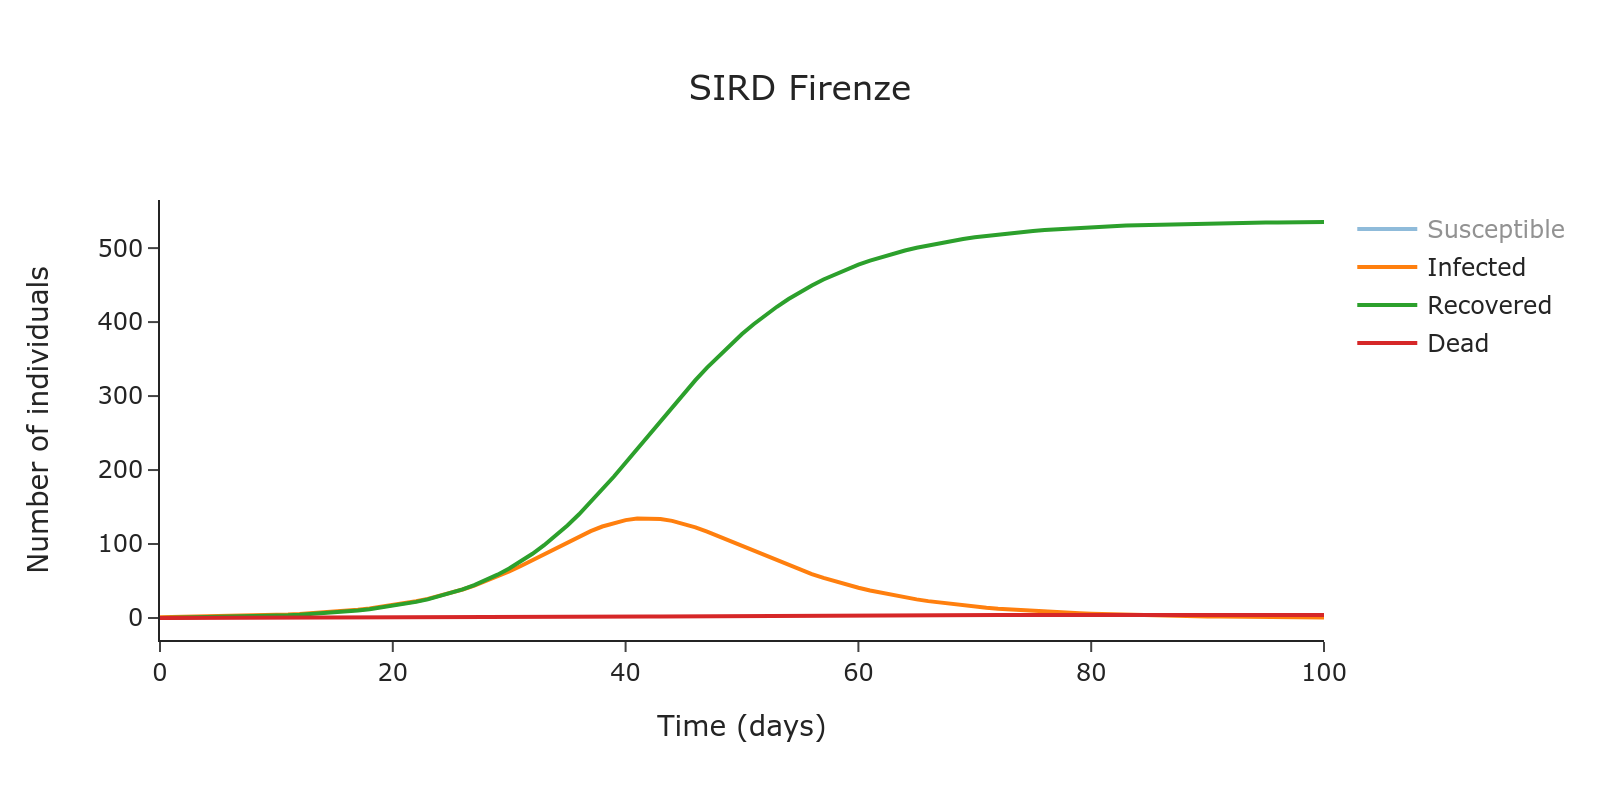

In [6]:
times = list(range(sirsol.shape[1]))

general_plot(t=times, 
             data=sirsol, 
             title='SIRD ' + province,
             traces_visibility=['legendonly'] + [True]*3,
             output_image=True,
             template='simple_white')

In [7]:
# Uncomment for interactive plots

#result = pd.DataFrame()
#for prov in covidpro_df.Province.unique():
#    S, I, R, D = sird(prov, pop_prov_df)
#    tmp = pd.DataFrame(np.column_stack([[prov]*len(S),range(len(S)),S,I,R,D]))
#    result = pd.concat([result, tmp])
#    
#result.columns = ["Province", "t", "S", "I", "R", "D"]
#result.reset_index(drop=True,inplace=True)

In [8]:
#inter_dropdown_plot(options=result.Province.unique(), 
#                    default_value='Firenze', 
#                    dropdown_label='Province',
#                    y=["S", "I", "R", "D"],
#                    legend_titles=['Susceptible', 'Infected', 'Recovered', 'Dead'],
#                    data=result,
#                    group_column='Province',
#                    x='t',
#                    title='COVID-19 trendlines of ',
#                    xtitle='Data',
#                    ytitle='Unità',
#                    traces_visibility=['legendonly',True,True,True],
#                    output_image=False)

In [9]:
mapping = {
    'New_cases': 2,
    'Curr_pos_cases': 2,
    'Tot_deaths': 4,
    'Deaths': ('Deaths', D),
    'Infected': ('New_cases', I)
}

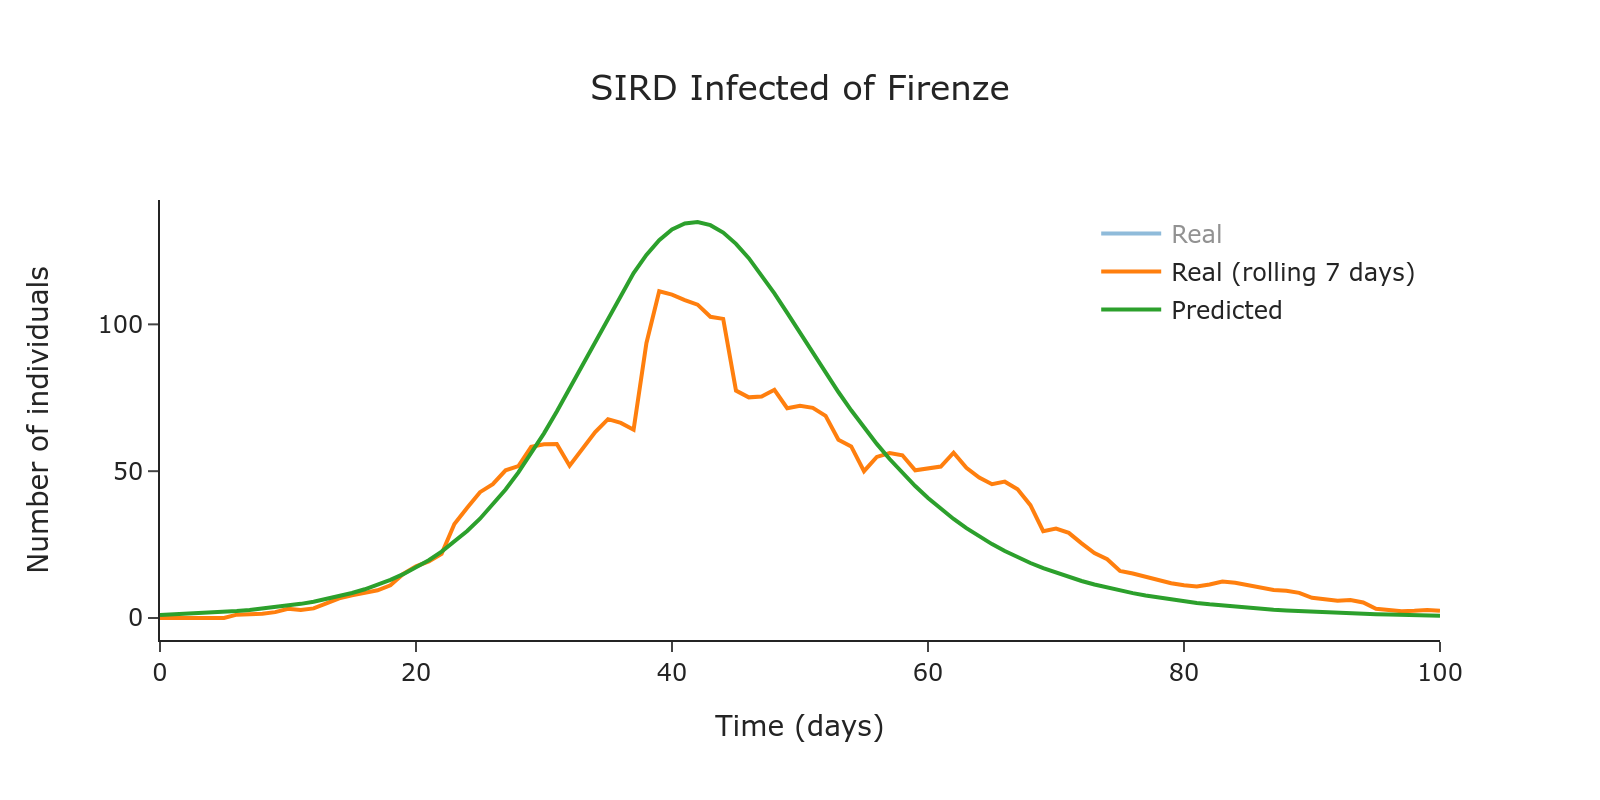

In [10]:
names, title, data, modes = data_for_plot('Infected', covidpro_df, mapping, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=modes,
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True],
             template='simple_white')

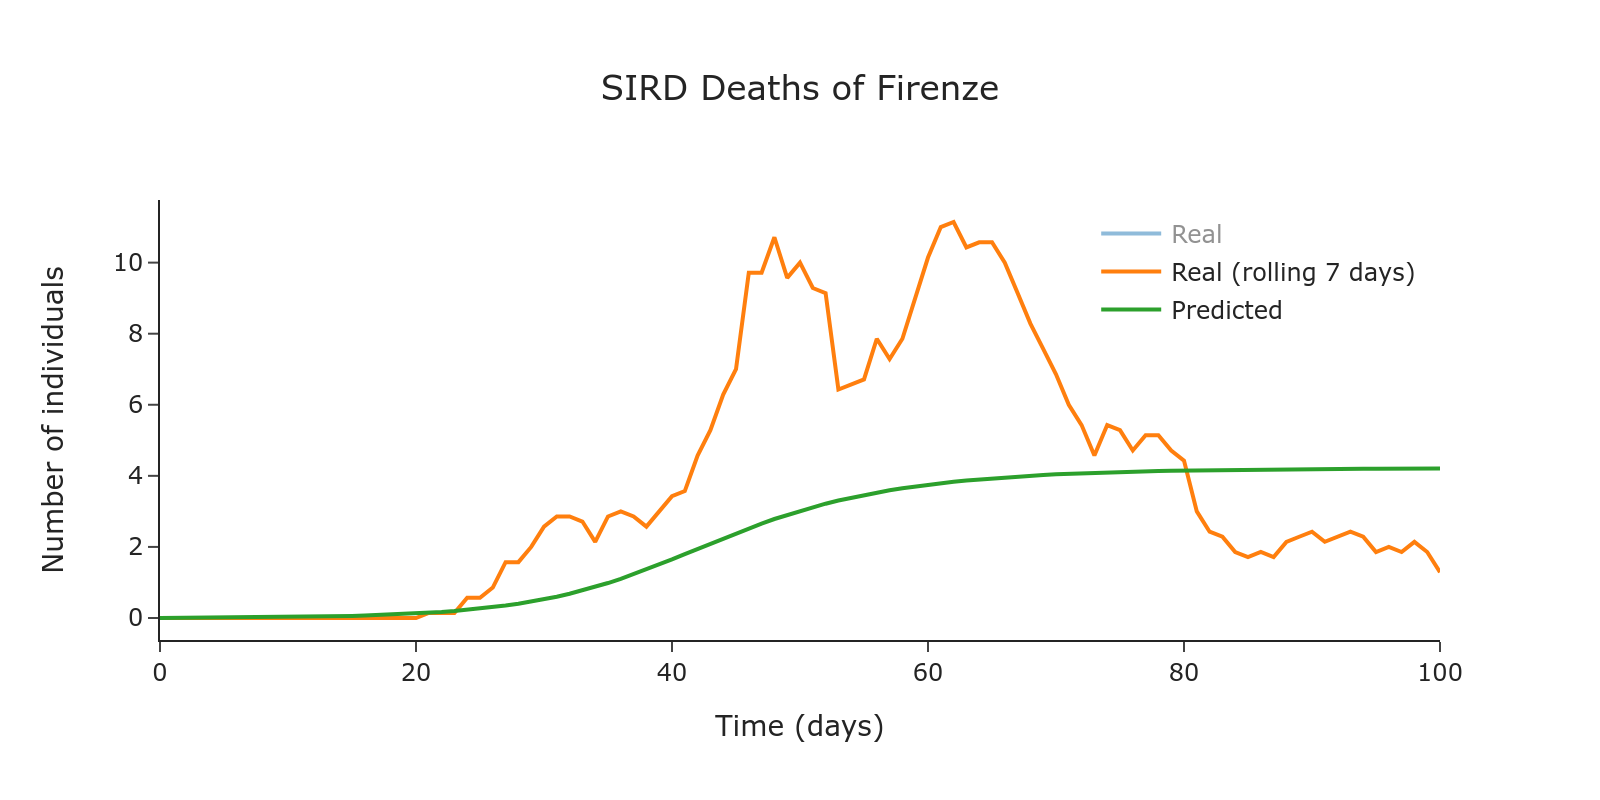

In [11]:
names, title, data, modes = data_for_plot('Deaths', covidpro_df, mapping, province)

general_plot(t=times,
             title=title,
             data=data, 
             names=names,
             modes=modes,
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True],
             template='simple_white')

In [12]:
result = pd.DataFrame()
for prov in covidpro_df.Province.unique():
    _, I, _, _ = sird(prov, pop_prov_df)
    names, _, data, _ = data_for_plot('Infected', covidpro_df, mapping, prov)
    tmp = pd.DataFrame(np.column_stack([[prov]*data[2].shape[0],range(data[2].shape[0]),data[0],data[1],data[2]]))
    result = pd.concat([result, tmp])
    
result.columns = ["Province", "t", "real", "real_roll", "pred"]
result.reset_index(drop=True,inplace=True)

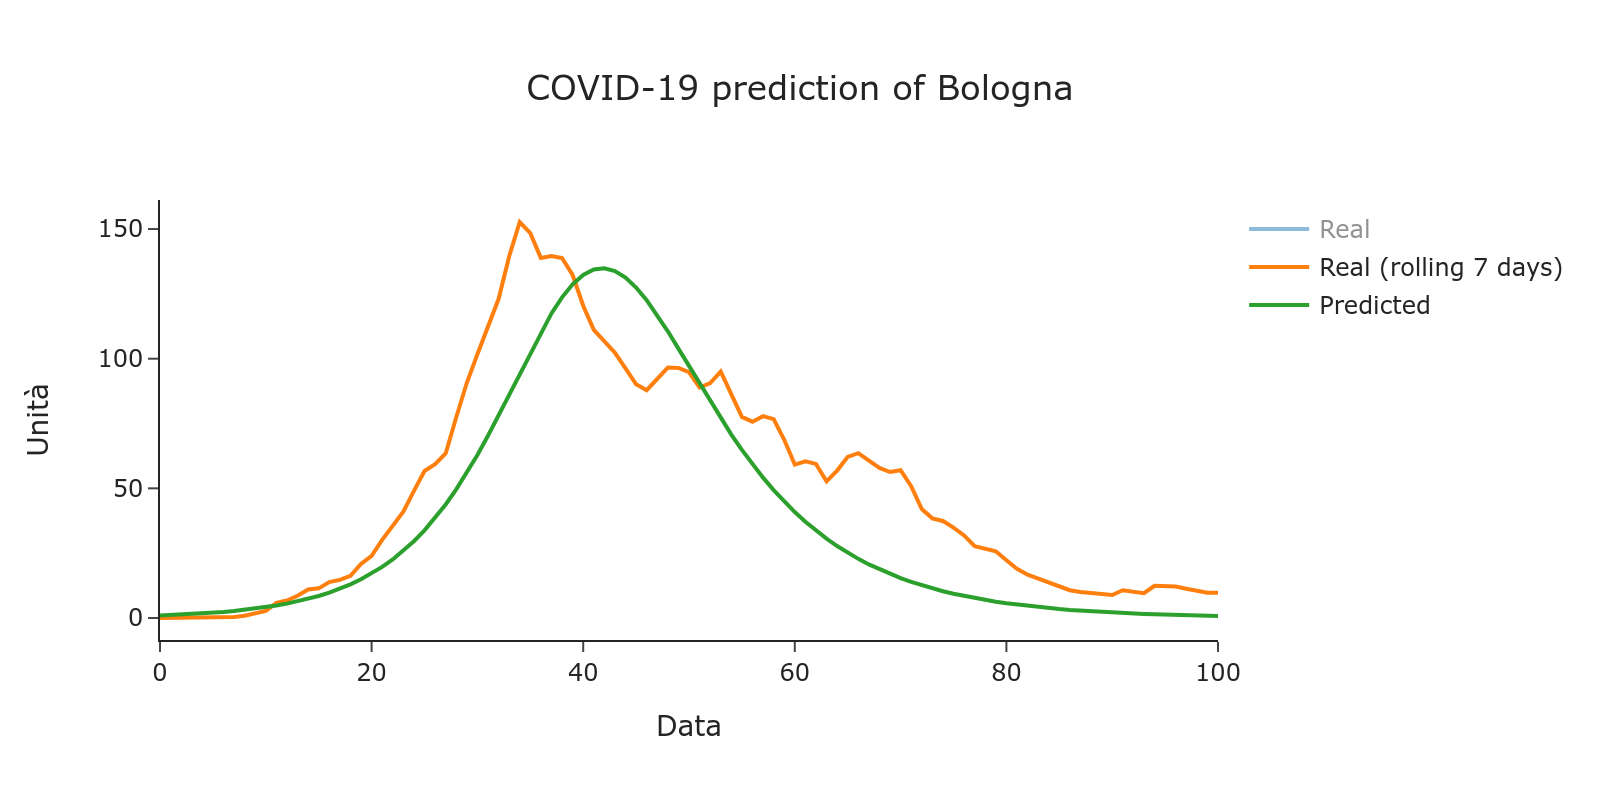

In [13]:
inter_dropdown_plot(options=result.Province.unique(), 
                    default_value='Bologna', 
                    dropdown_label='Province',
                    y=["real", "real_roll", "pred"],
                    legend_titles=names,
                    data=result,
                    group_column='Province',
                    x='t',
                    title='COVID-19 prediction of ',
                    xtitle='Data',
                    ytitle='Unità',
                    output_image=True,
                    traces_visibility=['legendonly',True,True],
                    template='simple_white')

## Parameter estimation for logistic Rt
SIRD model fitting using least squares

In [14]:
mapping['Deaths'] = 4

In [15]:
def fitter(x, R_0_start, k, x0, R_0_end):
    """
    Fitting function.

    Parameters
    ----------

    x : int
        The index of the object we want to get
        from `Model` (i.e.: x=2 for I, x=4 for D).
    
    R_0_start : float
        Starting value of RO
    
    k : float
        How quickly R0 declines. Lower values of k will
        let R0 need more time to become lower.
    
    x0 : int
        Value on the x-axis of the inflection point of R0.
        This can be interpreted as the day in which lockdown
        comes into effect.
    
    R_0_end : float
        Final value of RO
    
    Returns
    -------
    An array with the predictions
    """

    ret = Model(days, N, R_0_start, k, x0, R_0_end)
    return ret[mapping[compart]][x]

In [16]:
def get_model(province, compart, data_df, pop_df, params_init_min_max=None, query='20200603 > Date', outbreak_shift=20, window=7):
    data = data_df[data_df.Province == province].query(query)[compart]
    if compart in ['New_cases', 'Deaths']:
        data = data.rolling(window).mean().fillna(0)
    
    N = pop_df.loc[(pop_df.Territorio == province) & (pop_df.Eta == "Total")]['Value'].values[0]

    # {parameter: (initial guess, min value, max value)}
    if params_init_min_max == None:
        params_init_min_max = {
            "R_0_start": (3.5, 1.0, 6),
            "k": (0.3, 0.01, 5.0),
            "x0": (20, 0, 100),
            "R_0_end": (0.9, 0.1, 3.5)
        }

    days = outbreak_shift + len(data)

    if outbreak_shift >= 0:
        y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else:
        y_data = y_data[-outbreak_shift:]

    # [0, 1, ..., days]
    x_data = np.linspace(0, days-1, days, dtype=int)

    mod = lmfit.Model(fitter)

    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

    params = mod.make_params()

    return mod, params, y_data, x_data, days, N

### Cumulative infected - Firenze
No outbreak shift

In [17]:
province = 'Firenze'
compart = 'Curr_pos_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

In [18]:
result = mod.fit(y_data, params, method="leastsq", x=x_data)

In [19]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 100
    # variables        = 4
    chi-square         = 105385.793
    reduced chi-square = 1097.76867
    Akaike info crit   = 704.021293
    Bayesian info crit = 714.441973
[[Variables]]
    R_0_start:  3.81206010 +/- 0.15049668 (3.95%) (init = 3.5)
    k:          0.07997523 +/- 0.00238435 (2.98%) (init = 0.3)
    x0:         16.9708486 +/- 1.51143624 (8.91%) (init = 20)
    R_0_end:    1.01642933 +/- 0.00228584 (0.22%) (init = 0.9)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_start, x0)      = -1.000
    C(k, x0)              =  0.977
    C(R_0_start, k)       = -0.975
    C(k, R_0_end)         =  0.886
    C(x0, R_0_end)        =  0.788
    C(R_0_start, R_0_end) = -0.786


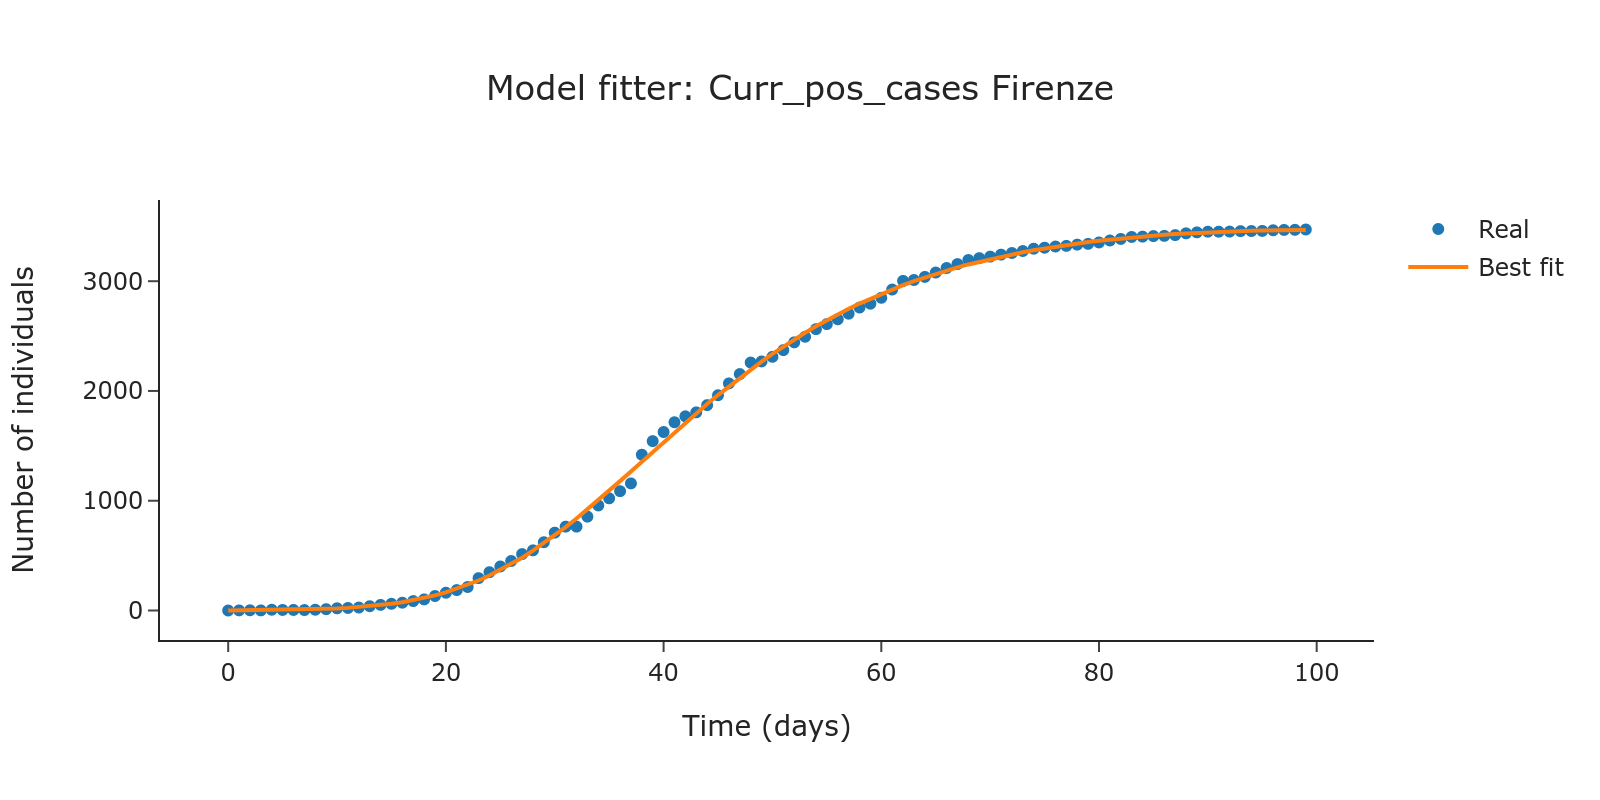

In [20]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [21]:
result.best_values

{'R_0_start': 3.812060097483168,
 'k': 0.07997522544854932,
 'x0': 16.970848640063867,
 'R_0_end': 1.0164293292922266}

### Daily infected - Firenze
No outbreak shift

In [22]:
compart = 'New_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

In [23]:
result = mod.fit(y_data, params, method="leastsq", x=x_data)

In [24]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 62
    # data points      = 100
    # variables        = 4
    chi-square         = 5137.83874
    reduced chi-square = 53.5191536
    Akaike info crit   = 401.921761
    Bayesian info crit = 412.342441
[[Variables]]
    R_0_start:  2.06045543 +/- 0.05430221 (2.64%) (init = 3.5)
    k:          0.14410995 +/- 0.02264343 (15.71%) (init = 0.3)
    x0:         35.1169430 +/- 0.95530878 (2.72%) (init = 20)
    R_0_end:    0.57782849 +/- 0.03555566 (6.15%) (init = 0.9)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_start, k)       = -0.933
    C(R_0_start, x0)      = -0.833
    C(k, R_0_end)         =  0.789
    C(R_0_start, R_0_end) = -0.606
    C(k, x0)              =  0.601


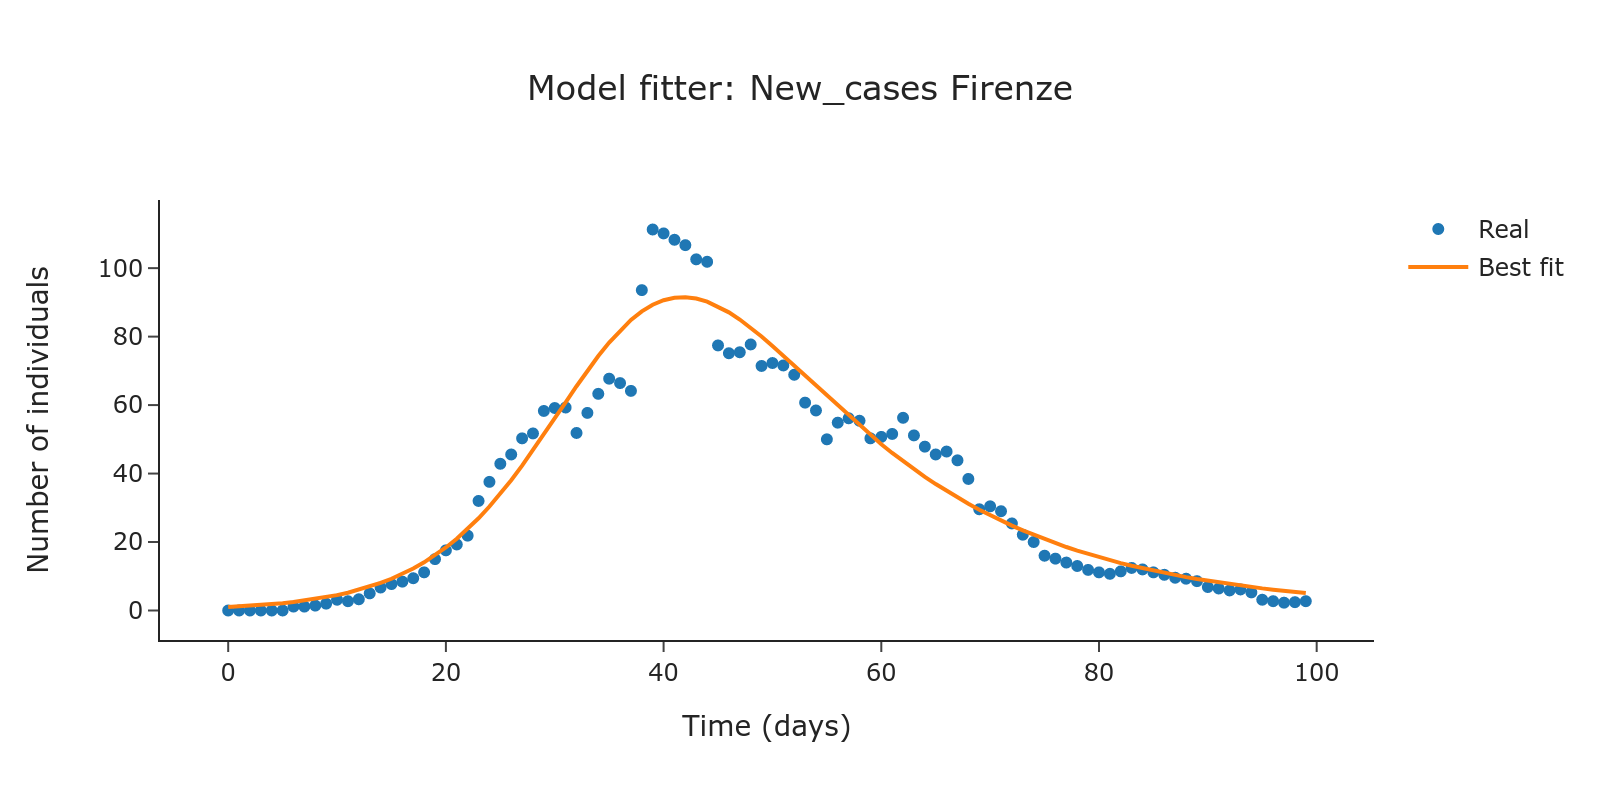

In [25]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [26]:
result.best_values

{'R_0_start': 2.060455433711362,
 'k': 0.14410994966710766,
 'x0': 35.11694298507976,
 'R_0_end': 0.5778284898400226}

In [27]:
sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

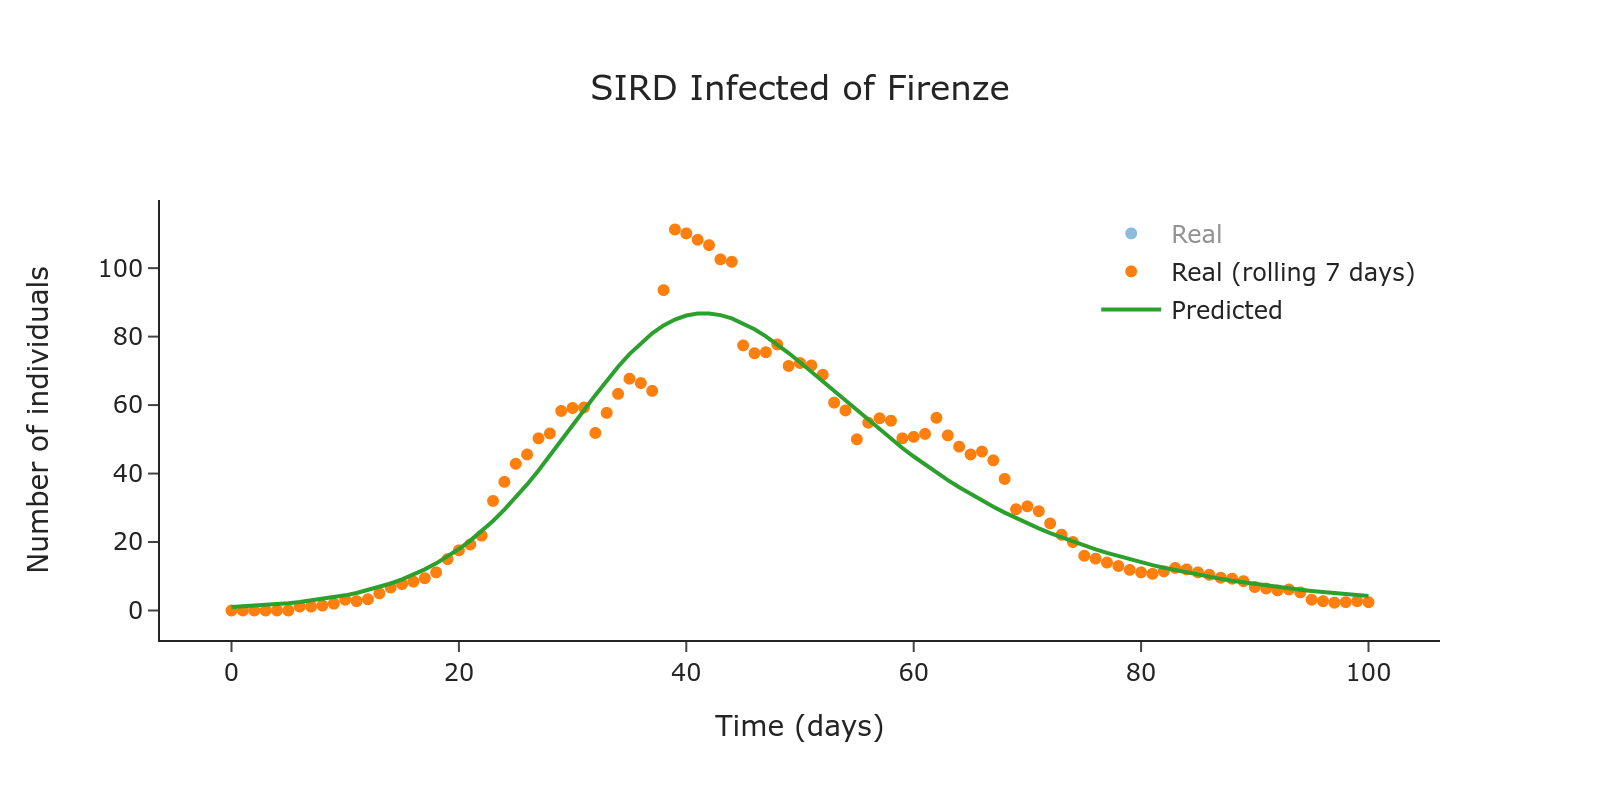

In [28]:
mapping = {
    'New_cases': 2,
    'Curr_pos_cases': 2,
    'Tot_deaths': 4,
    'Deaths': ('Deaths', D),
    'Infected': ('New_cases', I)
}

names, title, data, _ = data_for_plot('Infected', covidpro_df, mapping, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

### Daily infected - Firenze
Outbreak shift = 20

In [17]:
province = 'Firenze'
compart = 'New_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=20)

result = mod.fit(y_data, params, method="leastsq", x=x_data)

lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 237
    # data points      = 120
    # variables        = 4
    chi-square         = 5033.49977
    reduced chi-square = 43.3922394
    Akaike info crit   = 456.365487
    Bayesian info crit = 467.515454
[[Variables]]
    R_0_start:  1.53328819 +/- 0.00311711 (0.20%) (init = 3.5)
    k:          4.99999892 +/- 29.5008115 (590.02%) (init = 0.3)
    x0:         60.6333238 +/- 0.30704301 (0.51%) (init = 20)
    R_0_end:    0.66221364 +/- 0.01273164 (1.92%) (init = 0.9)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_start, x0) = -0.668
    C(x0, R_0_end)   = -0.516
    C(R_0_start, k)  = -0.213
    C(k, x0)         = -0.122


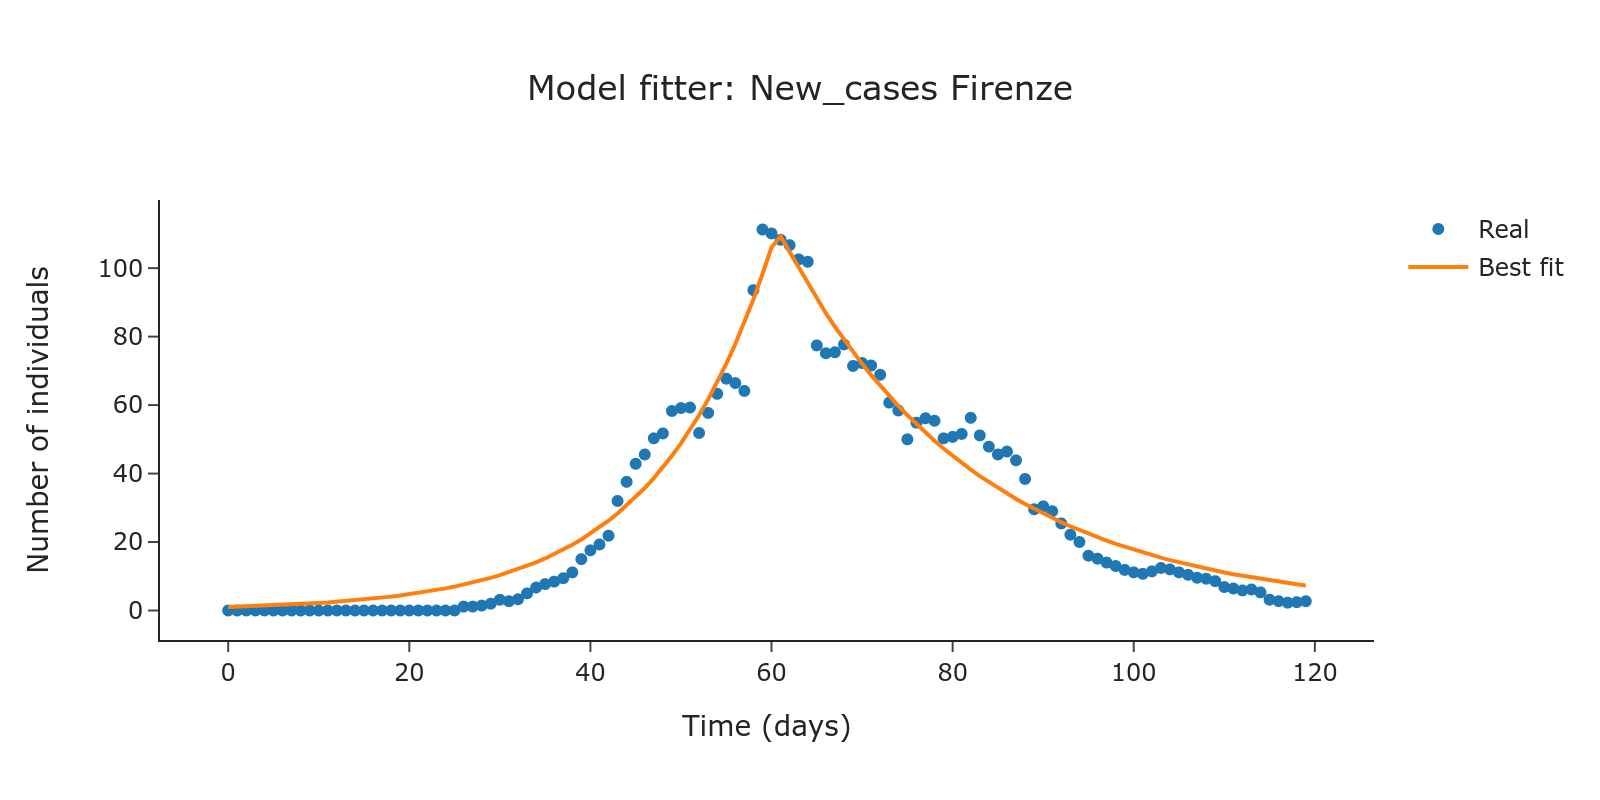

In [18]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [19]:
result.best_values

{'R_0_start': 1.53328819489071,
 'k': 4.999998923061777,
 'x0': 60.63332379814293,
 'R_0_end': 0.6622136433583652}

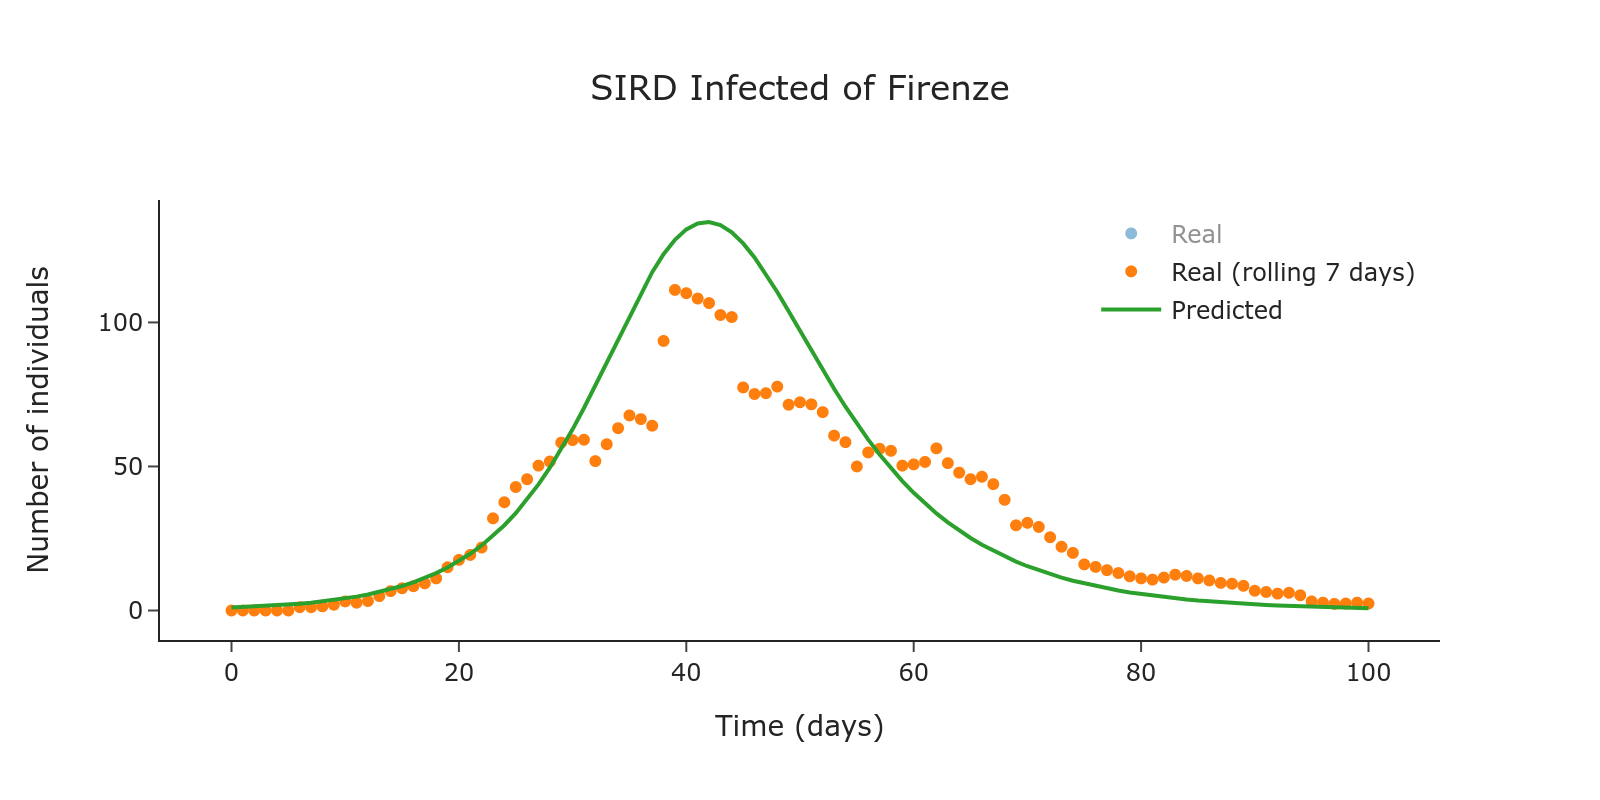

In [20]:
sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

names, title, data, _ = data_for_plot('Infected', covidpro_df, mapping, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

### Daily infected - Bologna
No outbreak shift

In [21]:
province = 'Bologna'
compart = 'New_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

result = mod.fit(y_data, params, method="leastsq", x=x_data)

lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 70
    # data points      = 100
    # variables        = 4
    chi-square         = 5331.30165
    reduced chi-square = 55.5343921
    Akaike info crit   = 405.618051
    Bayesian info crit = 416.038732
[[Variables]]
    R_0_start:  2.08105256 +/- 0.01126800 (0.54%) (init = 3.5)
    k:          0.71178941 +/- 0.17415643 (24.47%) (init = 0.3)
    x0:         32.7216667 +/- 0.27473528 (0.84%) (init = 20)
    R_0_end:    0.73195179 +/- 0.00840579 (1.15%) (init = 0.9)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_start, x0)      = -0.885
    C(R_0_start, k)       = -0.714
    C(k, x0)              =  0.454
    C(k, R_0_end)         =  0.408
    C(x0, R_0_end)        = -0.223
    C(R_0_start, R_0_end) = -0.170


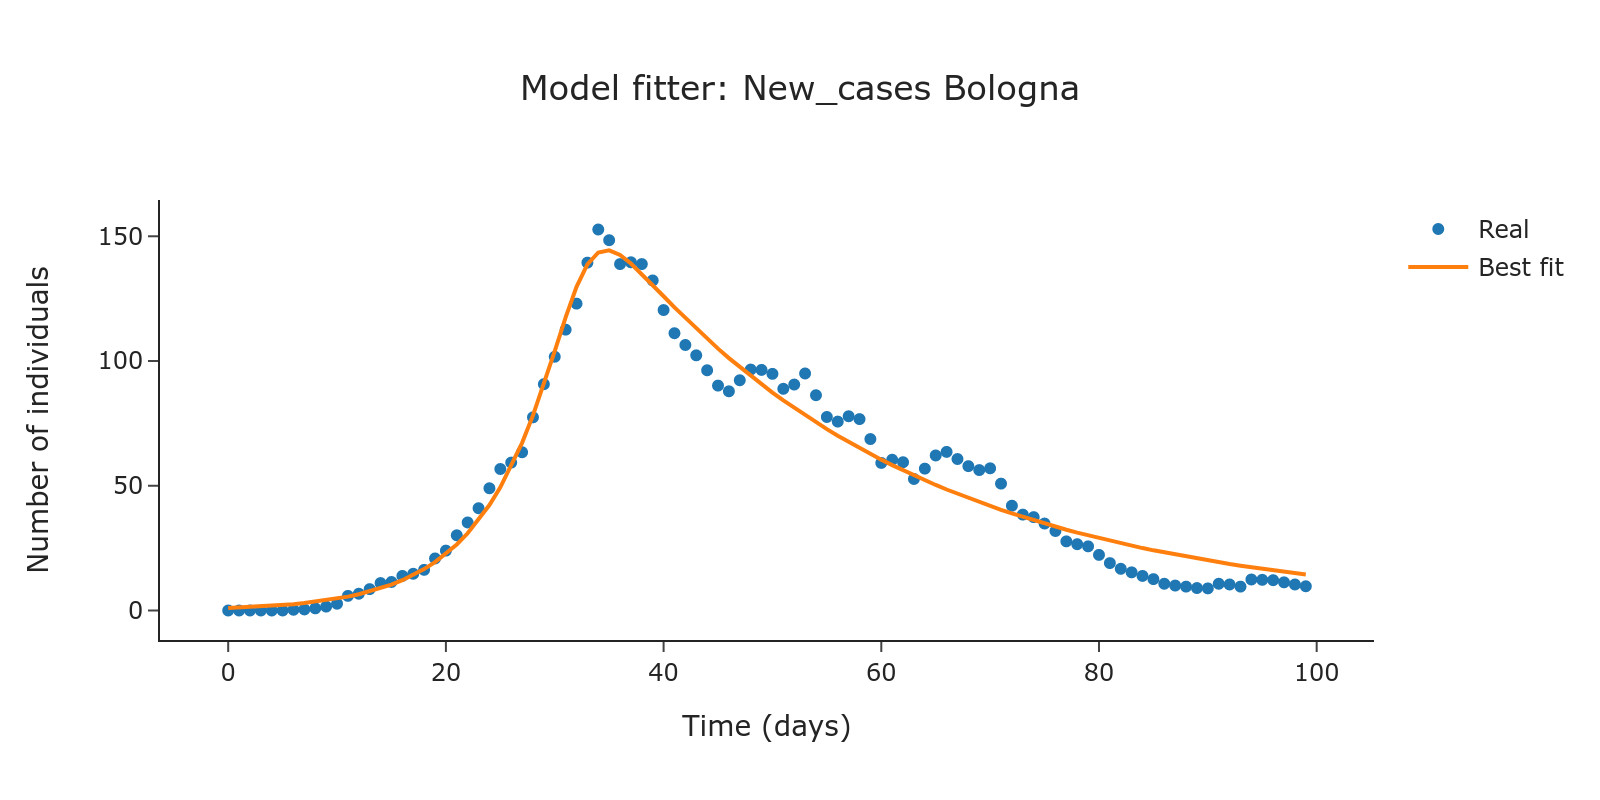

In [22]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

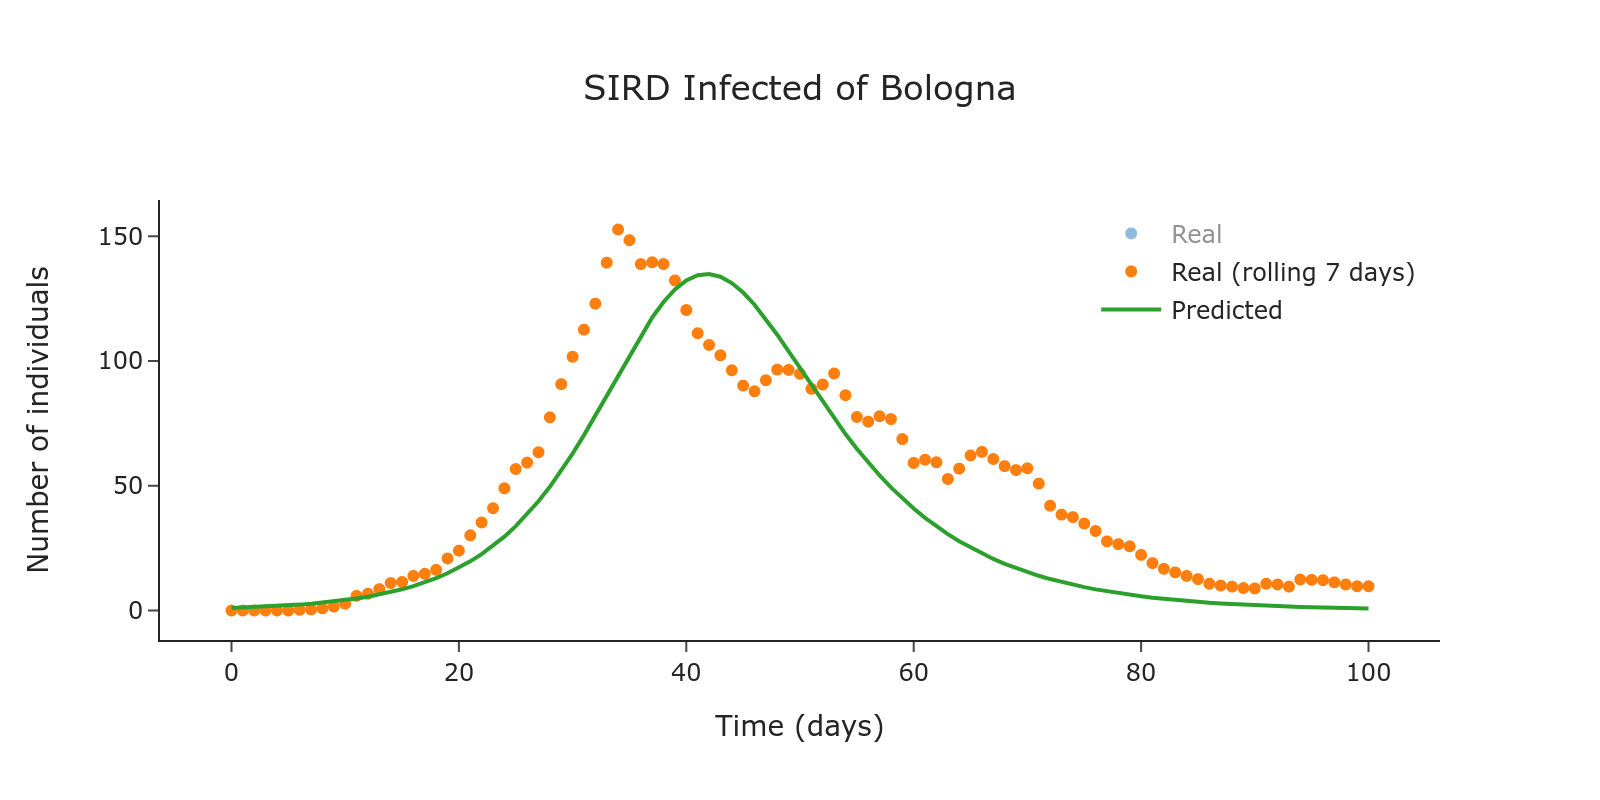

In [23]:
sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

names, title, data, _ = data_for_plot('Infected', covidpro_df, mapping, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

### Skewed gaussian param estimation - Bologna
No outbreak shift

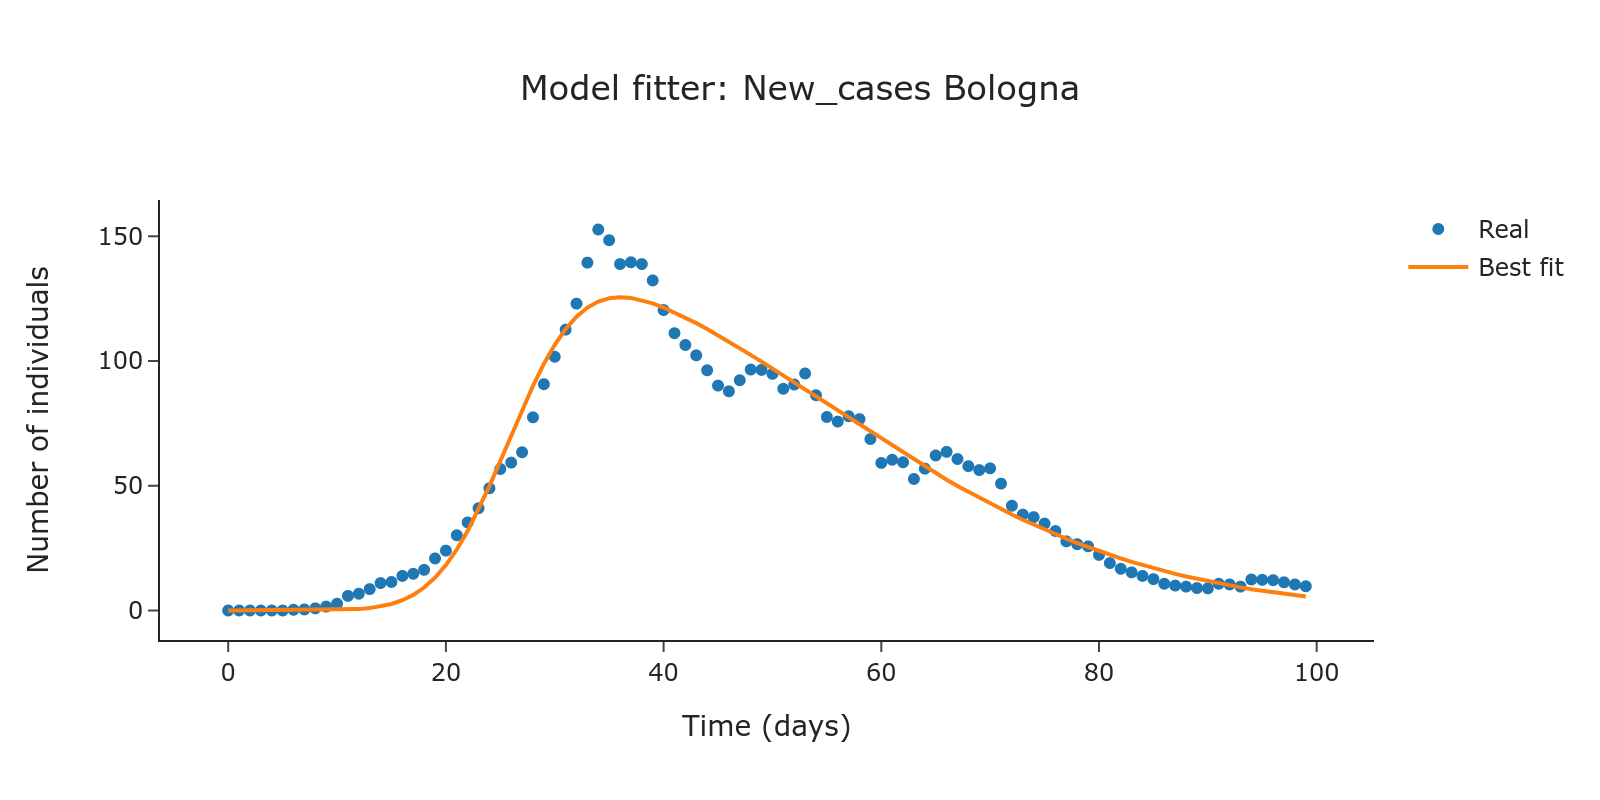

In [24]:
from lmfit.models import SkewedGaussianModel

province = 'Bologna'
compart = 'New_cases'

_, _, y_data, x_data, _, _ = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

model = SkewedGaussianModel()
params = model.guess(y_data, x=x_data)

result = model.fit(y_data, params, x=x_data)

general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [26]:
lmfit.fit_report(result)

'[[Fit Statistics]]\n    # fitting method   = leastsq\n    # function evals   = 81\n    # data points      = 100\n    # variables        = 4\n    chi-square         = 6841.04514\n    reduced chi-square = 71.2608869\n    Akaike info crit   = 430.552561\n    Bayesian info crit = 440.973242\n[[Variables]]\n    amplitude:  4980.53084 +/- 80.1918752 (1.61%) (init = 6872.143)\n    center:     25.8493059 +/- 0.30152642 (1.17%) (init = 42.56667)\n    sigma:      28.9202731 +/- 0.66437112 (2.30%) (init = 15)\n    gamma:      5.45079057 +/- 0.50824227 (9.32%) (init = 0)\n[[Correlations]] (unreported correlations are < 0.100)\n    C(center, sigma)     = -0.591\n    C(sigma, gamma)      =  0.552\n    C(amplitude, sigma)  =  0.522\n    C(center, gamma)     = -0.377\n    C(amplitude, center) = -0.290'

## Parameter estimation using LinearRegression
Compute parameters for each day and then predict new days

In [41]:
regione = 'Piemonte'
pop = get_region_pop(regione, pop_prov_df, prov_list_df)

filtered_df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == regione][['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi', 'nuovi_positivi']]

#PROVA
filtered_df = filtered_df.query('20200531 > data')

filtered_df['suscettibili'] = pop - filtered_df['totale_casi']

filtered_df = filtered_df[['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'suscettibili', 'nuovi_positivi']]

In [42]:
n = filtered_df.shape[0]

gamma = np.diff(filtered_df['dimessi_guariti'].values)/filtered_df.iloc[:n-1]['totale_positivi'].values
alpha = np.diff(filtered_df['deceduti'].values)/filtered_df.iloc[:n-1]['totale_positivi'].values
beta = (pop/filtered_df.iloc[:n-1]['suscettibili'].values)*(np.diff(filtered_df['totale_positivi'].values)+np.diff(filtered_df['dimessi_guariti'].values)+np.diff(filtered_df['deceduti'].values))/filtered_df.iloc[:n-1]['totale_positivi'].values
R0 = beta/(gamma+alpha)

In [43]:
def fix_arr(arr):
    arr[arr < 0] = 0
    arr[np.isinf(arr)] = 0
    return np.nan_to_num(arr)

gamma = fix_arr(gamma)
alpha = fix_arr(alpha)
beta = fix_arr(beta)
R0 = fix_arr(R0)

In [44]:
def lag_data(data, lag=5, return_all=False):
    N = len(data)
    X = np.empty(shape=(N-lag, lag+1))

    for i in range(lag, N):
        X[i-lag,] = [data[i-j] for j in range(lag+1)]
    
    if not return_all:
        return X[-1,1:]
    else:
        return X[:,1:], X[:,0]

In [45]:
from sklearn.linear_model import LinearRegression

lag = 7
reg_beta = LinearRegression().fit(*lag_data(beta, lag, True))
reg_gamma = LinearRegression().fit(*lag_data(gamma, lag, True))
reg_alpha = LinearRegression().fit(*lag_data(alpha, lag, True))

In [46]:
days_to_predict = 14

S = np.zeros(days_to_predict + 2)
I = np.zeros(days_to_predict + 2)
R = np.zeros(days_to_predict + 2)
D = np.zeros(days_to_predict + 2)
S[0] = filtered_df.iloc[-1]['suscettibili']
I[0] = filtered_df.iloc[-1]['totale_positivi']
R[0] = filtered_df.iloc[-1]['dimessi_guariti']
D[0] = filtered_df.iloc[-1]['deceduti']

for i in range(days_to_predict + 1):
    _beta = fix_arr(reg_beta.predict(lag_data(beta, lag).reshape(1, -1)))
    _gamma = fix_arr(reg_gamma.predict(lag_data(gamma, lag).reshape(1, -1)))
    _alpha = fix_arr(reg_alpha.predict(lag_data(alpha, lag).reshape(1, -1)))

    beta = np.append(beta, _beta, axis = 0)
    gamma = np.append(gamma, _gamma, axis = 0)
    alpha = np.append(alpha, _alpha, axis = 0)

    dIdt = np.round((1 + _beta * (S[i]/pop) - _gamma - _alpha)*I[i])
    dRdt = np.round(R[i] + _gamma * I[i])
    dDdt = np.round(D[i] + _alpha * I[i])
    dSdt = pop-dIdt[0]-dRdt[0]-dDdt[0]

    S[i+1] = dSdt
    I[i+1] = dIdt
    R[i+1] = dRdt
    D[i+1] = dDdt

S = S[1:]
I = I[1:]
R = R[1:]
D = D[1:]

In [47]:
dates = pd.date_range(start=(filtered_df.iloc[-1]['data'] + pd.DateOffset(1)).strftime('%Y-%m-%d'), periods=days_to_predict + 1)

tmp_df = pd.DataFrame(np.column_stack([np.zeros(days_to_predict + 1), I, R, D, S]),
    columns = [
        'data',
        'totale_positivi', 
        'dimessi_guariti',
        'deceduti', 
        'suscettibili'])

tmp_df['data'] = dates

In [48]:
filtered_df = pd.concat([filtered_df, tmp_df], ignore_index=True)

In [49]:
filtered_df['nuovi_positivi'] = [0]+list(np.diff(filtered_df['totale_positivi'].values)+np.diff(filtered_df['dimessi_guariti'].values)+np.diff(filtered_df['deceduti'].values))

filtered_df['nuovi_positivi'] = filtered_df['nuovi_positivi'].apply(lambda x: 0 if x < 0 else x)

beta = np.append(beta, np.zeros((1,)), axis = 0)
gamma = np.append(gamma, np.zeros((1,)), axis = 0)
alpha = np.append(alpha, np.zeros((1,)), axis = 0)

filtered_df['beta'] = beta
filtered_df['gamma'] = gamma
filtered_df['alpha'] = alpha
filtered_df['R0'] = fix_arr(beta/(gamma+alpha))
filtered_df = filtered_df[:-1]

In [50]:
filtered_df = filtered_df.astype({'totale_positivi': 'int32',
'dimessi_guariti': 'int32', 'deceduti': 'int32', 'suscettibili': 'int32', 'nuovi_positivi': 'int32'})

In [51]:
filtered_df

,data,totale_positivi,dimessi_guariti,deceduti,suscettibili,nuovi_positivi,beta,gamma,alpha,R0
0,2020-02-24 18:00:00,3,0,0,4341372,0,0.000000,0.000000,0.000000,0.000000
1,2020-02-25 18:00:00,3,0,0,4341372,0,0.000000,0.000000,0.000000,0.000000
2,2020-02-26 18:00:00,3,0,0,4341372,0,0.000000,0.000000,0.000000,0.000000
3,2020-02-27 18:00:00,2,0,0,4341373,0,4.500002,0.000000,0.000000,0.000000
4,2020-02-28 18:00:00,11,0,0,4341364,9,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
106,2020-06-09 00:00:00,3112,24772,4017,4309474,119,0.037502,0.094165,0.005110,0.377761
107,2020-06-10 00:00:00,2919,25065,4033,4309358,116,0.039899,0.094125,0.004956,0.402697
108,2020-06-11 00:00:00,2745,25340,4047,4309243,115,0.040422,0.095022,0.005295,0.402948
109,2020-06-12 00:00:00,2580,25601,4062,4309132,111,0.039411,0.103776,0.005465,0.360775


In [52]:
real_df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == regione][['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi', 'nuovi_positivi']]

real_df = real_df.query('20200612 > data')

real_df['suscettibili'] = pop - real_df['totale_casi']

real_df = real_df[['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'suscettibili', 'nuovi_positivi']]

real_df

,data,totale_positivi,dimessi_guariti,deceduti,suscettibili,nuovi_positivi
13,2020-02-24 18:00:00,3,0,0,4341372,3
34,2020-02-25 18:00:00,3,0,0,4341372,0
55,2020-02-26 18:00:00,3,0,0,4341372,0
76,2020-02-27 18:00:00,2,0,0,4341373,-1
97,2020-02-28 18:00:00,11,0,0,4341364,9
...,...,...,...,...,...,...
2197,2020-06-07 17:00:00,3962,22952,3941,4310520,10
2218,2020-06-08 17:00:00,3866,23049,3954,4310506,14
2239,2020-06-09 17:00:00,3671,23258,3961,4310485,21
2260,2020-06-10 17:00:00,3372,23568,3976,4310459,26


In [39]:
# Run if we want to show only the real predicted points
# in the graph and not the entire line

filtered_df['nuovi_positivi'] = [None]*(filtered_df.shape[0]-days_to_predict) + list(filtered_df.iloc[filtered_df.shape[0]-days_to_predict:]['nuovi_positivi'])
filtered_df['deceduti'] = [None]*(filtered_df.shape[0]-days_to_predict) + list(filtered_df.iloc[filtered_df.shape[0]-days_to_predict:]['deceduti'])
filtered_df['dimessi_guariti'] = [None]*(filtered_df.shape[0]-days_to_predict) + list(filtered_df.iloc[filtered_df.shape[0]-days_to_predict:]['dimessi_guariti'])
filtered_df['totale_positivi'] = [None]*(filtered_df.shape[0]-days_to_predict) + list(filtered_df.iloc[filtered_df.shape[0]-days_to_predict:]['totale_positivi'])

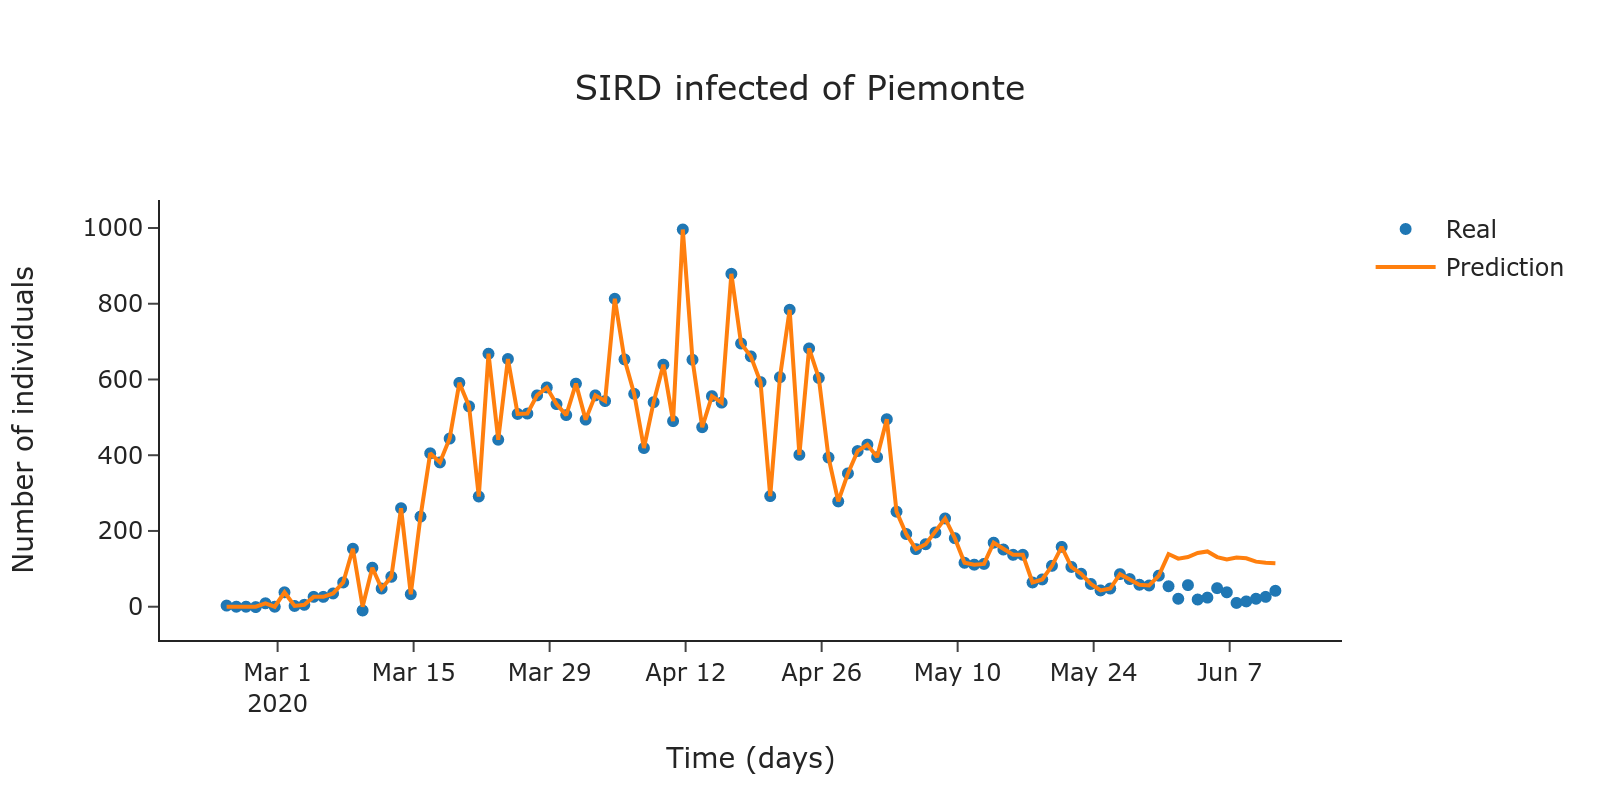

In [53]:
general_plot(t=real_df['data'],
             title='SIRD infected of ' + regione,
             data=[real_df['nuovi_positivi'].values, filtered_df['nuovi_positivi'].values],
             names=['Real', 'Prediction'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

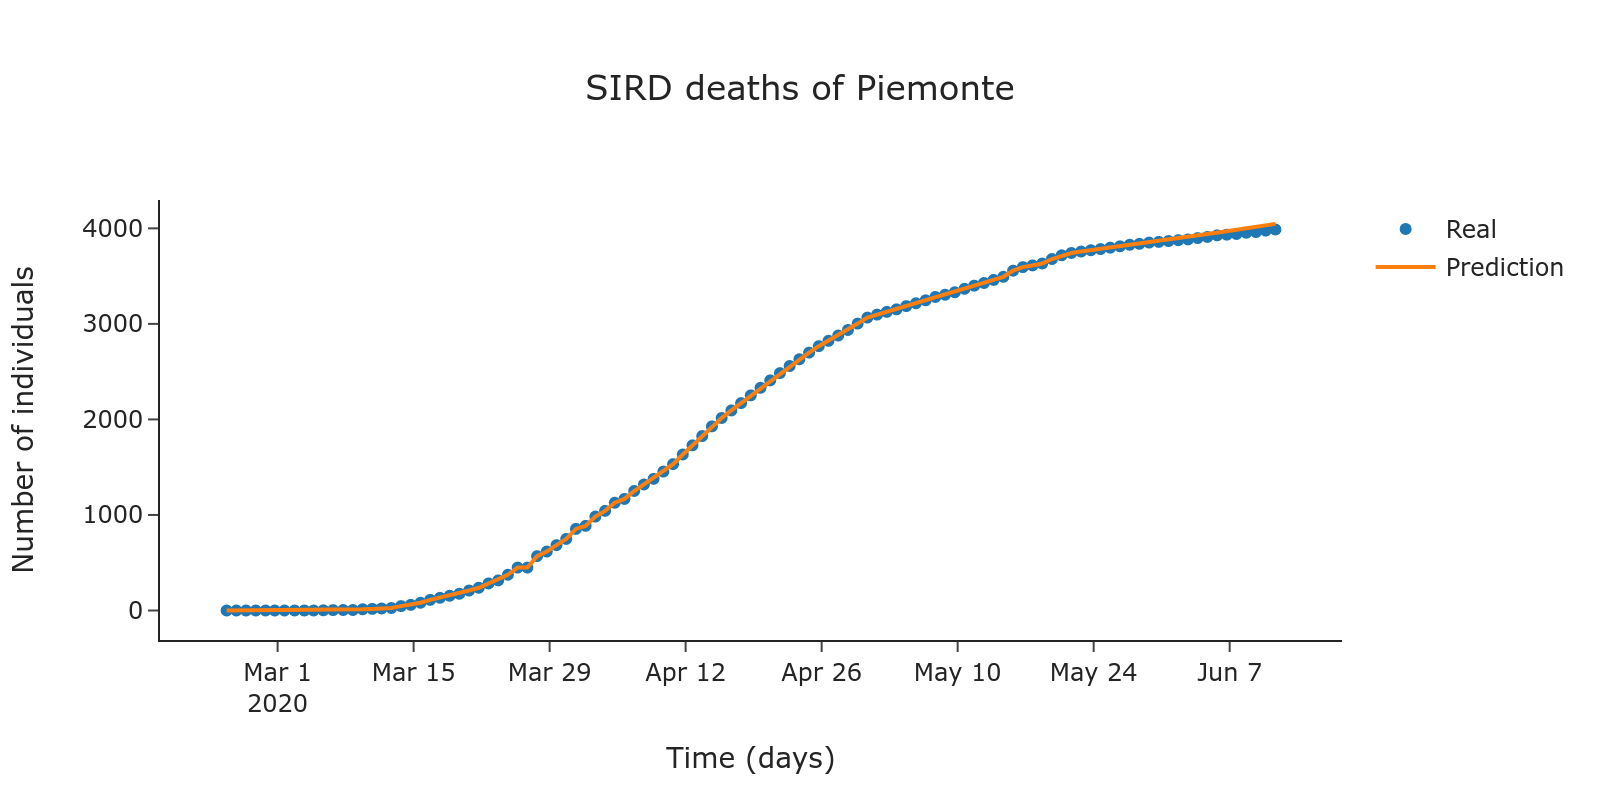

In [54]:
general_plot(t=real_df['data'],
             title='SIRD deaths of ' + regione,
             data=[real_df['deceduti'].values, filtered_df['deceduti'].values],
             names=['Real', 'Prediction'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

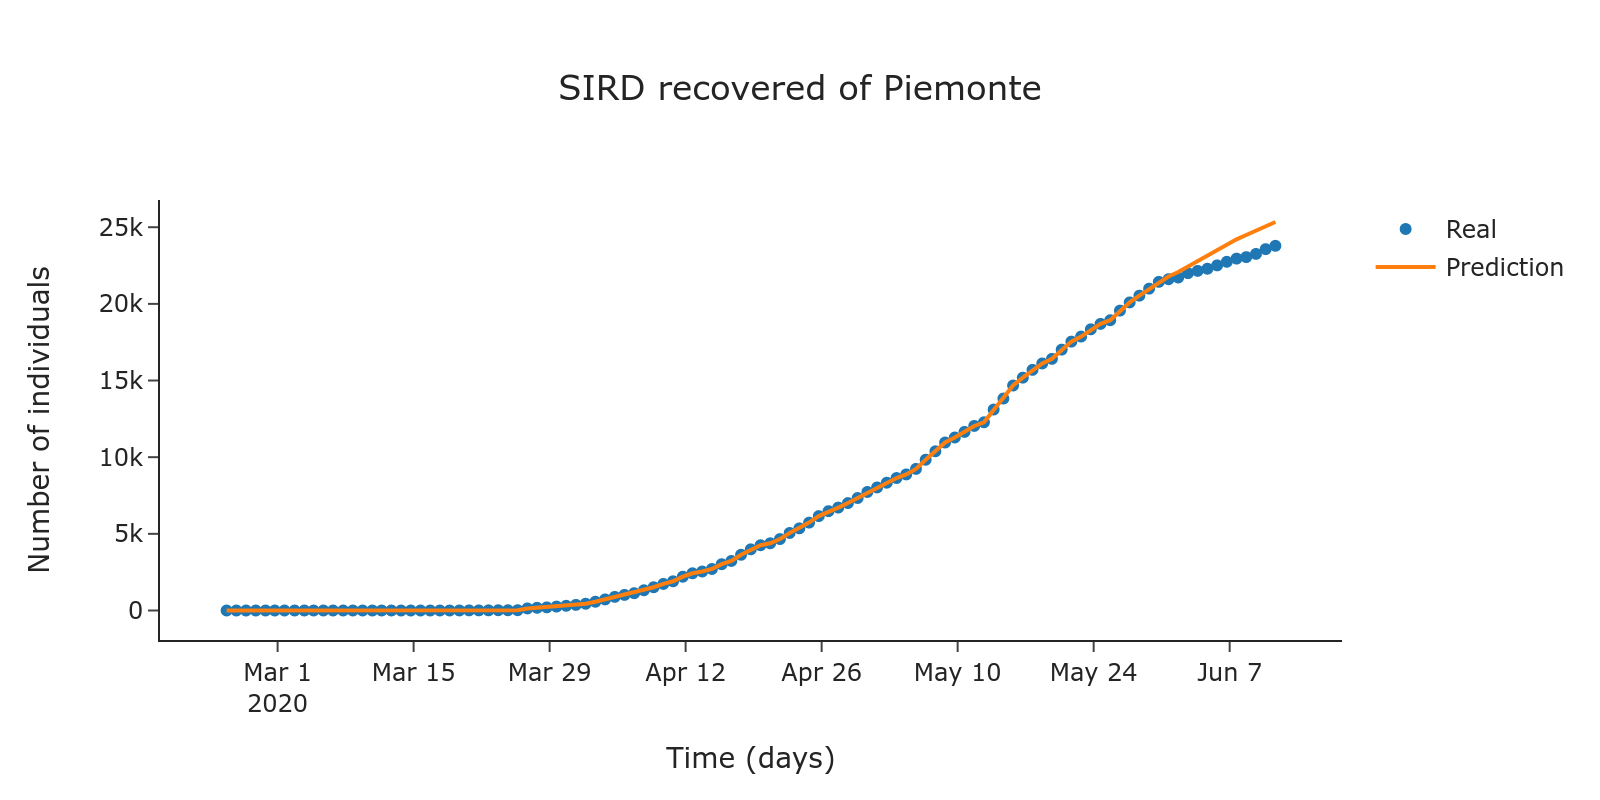

In [55]:
general_plot(t=real_df['data'],
             title='SIRD recovered of ' + regione,
             data=[real_df['dimessi_guariti'].values, filtered_df['dimessi_guariti'].values],
             names=['Real', 'Prediction'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

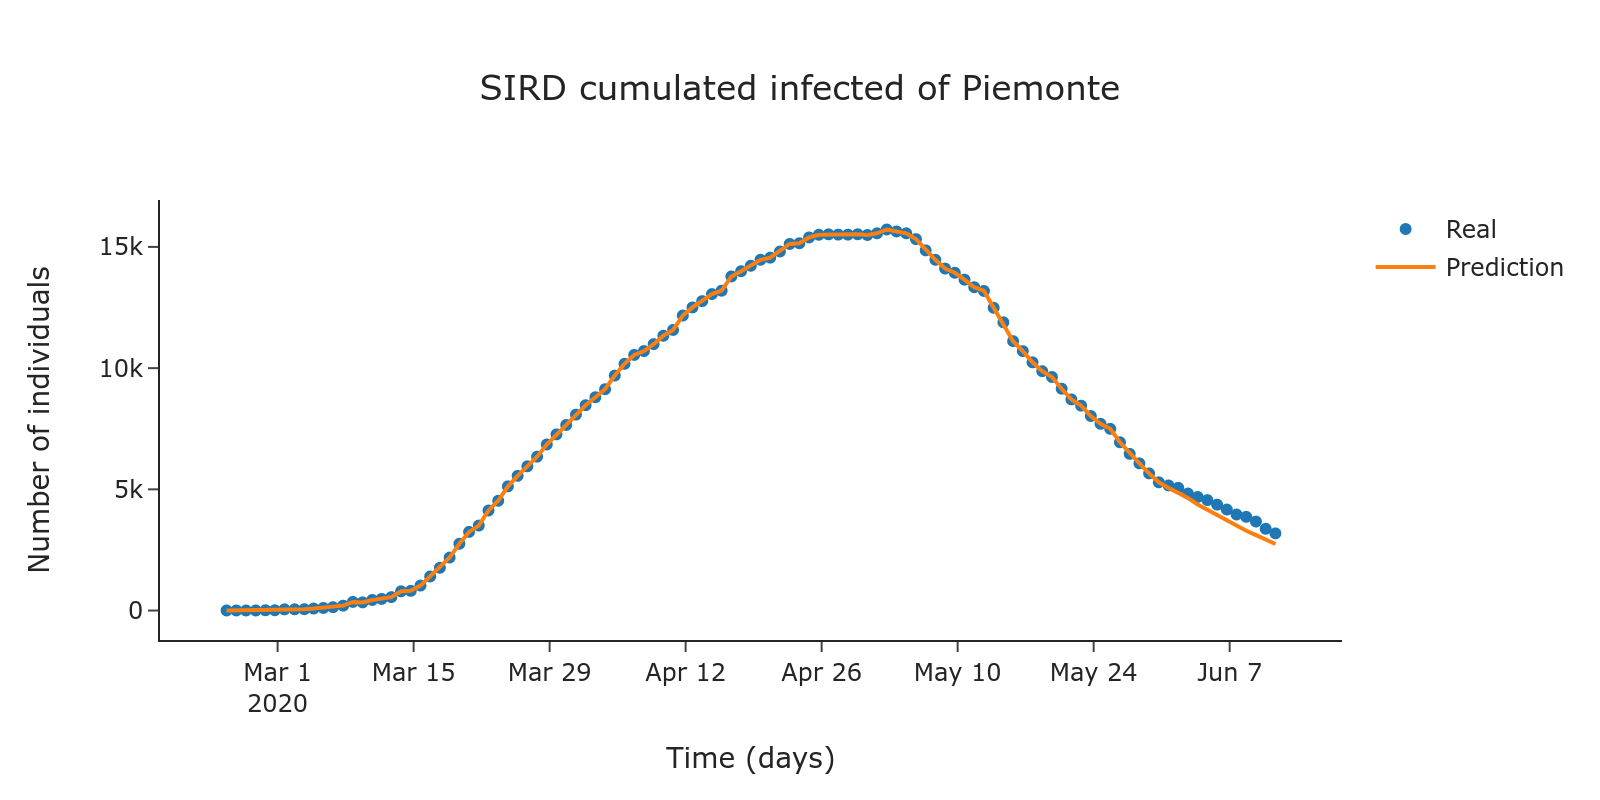

In [56]:
general_plot(t=real_df['data'],
             title='SIRD cumulated infected of ' + regione,
             data=[real_df['totale_positivi'].values, filtered_df['totale_positivi'].values],
             names=['Real', 'Prediction'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

## New SIRD test using odeint for solving
### Parameter estimation

In [14]:
def _logistic_R0(t, R_0_start, k, x0, R_0_end):
    """
    R0 moduled as logistic function
    """
    
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def _beta(t, R_0_start, k, x0, R_0_end, gamma):
    """
    Computes beta at a given time `t`
    """

    return _logistic_R0(t, R_0_start, k, x0, R_0_end) * gamma

def sird_deriv(y, t, N, gamma, alpha, R_0_start, k, x0, R_0_end, beta):
    """
    Computes SIRD model
    """

    S, I, R, D = y
    dSdt = -_beta(t, R_0_start, k, x0, R_0_end, gamma) * S * I / N
    dIdt = -dSdt - (1 - alpha) * gamma * I - alpha * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * I
    return dSdt, dIdt, dRdt, dDdt

def fitter(x, R_0_start, k, x0, R_0_end, alpha, gamma):
    ret = Model(days, N, R_0_start, k, x0, R_0_end, alpha, gamma)
    return ret[mapping[compart]][x]

def Model(days, N, R_0_start, k, x0, R_0_end, alpha, gamma):
    y0 = N-1.0, 1.0, 0.0, 0.0,
    times = range(0, days)

    sirsol = odeint(sird_deriv, y0, times, args=(N, gamma, alpha, R_0_start, k, x0, R_0_end, _beta))

    S, I, R, D = sirsol.T
    R0_over_time = [_beta(i, R_0_start, k, x0, R_0_end, gamma)/gamma for i in range(len(times))]

    return times, S, I, R, D, R0_over_time

def get_model(province, compart, data_df, pop_df, params_init_min_max=None, query='20200603 > Date', outbreak_shift=20, window=7):
    data = data_df[data_df.Province == province].query(query)[compart]
    if compart in ['New_cases', 'Deaths']:
        data = data.rolling(window).mean().fillna(0)
    
    N = pop_df.loc[(pop_df.Territorio == province) & (pop_df.Eta == "Total")]['Value'].values[0]

    # {parameter: (initial guess, min value, max value)}
    if params_init_min_max == None:
        params_init_min_max = {
            "R_0_start": (3.5, 1.0, 6),
            "k": (0.3, 0.01, 5.0),
            "x0": (20, 0, 100),
            "R_0_end": (0.9, 0.01, 3.5),
            "alpha": (0.1, 0.00000001, 1),
            "gamma": (1/7, 0.00000001, 1)
        }

    days = outbreak_shift + len(data)

    if outbreak_shift >= 0:
        y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else:
        y_data = y_data[-outbreak_shift:]

    # [0, 1, ..., days]
    x_data = np.linspace(0, days-1, days, dtype=int)

    mod = lmfit.Model(fitter)

    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

    params = mod.make_params()

    return mod, params, y_data, x_data, days, N

In [15]:
mapping['Deaths'] = 4

In [16]:
province = 'Firenze'
compart = 'Curr_pos_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

In [17]:
result = mod.fit(y_data, params, method="leastsq", x=x_data)

In [18]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 315
    # data points      = 100
    # variables        = 6
    chi-square         = 104885.665
    reduced chi-square = 1115.80494
    Akaike info crit   = 707.545594
    Bayesian info crit = 723.176615
[[Variables]]
    R_0_start:  4.00060097 +/- 15921.8921 (397987.51%) (init = 3.5)
    k:          0.08401433 +/- 0.00626347 (7.46%) (init = 0.3)
    x0:         18.4122033 +/- 2.33525570 (12.68%) (init = 20)
    R_0_end:    1.32125873 +/- 5259.92217 (398099.33%) (init = 0.9)
    alpha:      0.04520277 +/- 619.101855 (1369610.56%) (init = 0.1)
    gamma:      0.14015531 +/- 557.884284 (398047.20%) (init = 0.1428571)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_end, alpha)     =  1.000
    C(R_0_start, gamma)   = -1.000
    C(R_0_start, R_0_end) =  1.000
    C(R_0_end, gamma)     = -1.000
    C(R_0_start, alpha)   =  1.000
    C(alpha, gamma)       = -1.000
    C(k, x0)              =  0.970


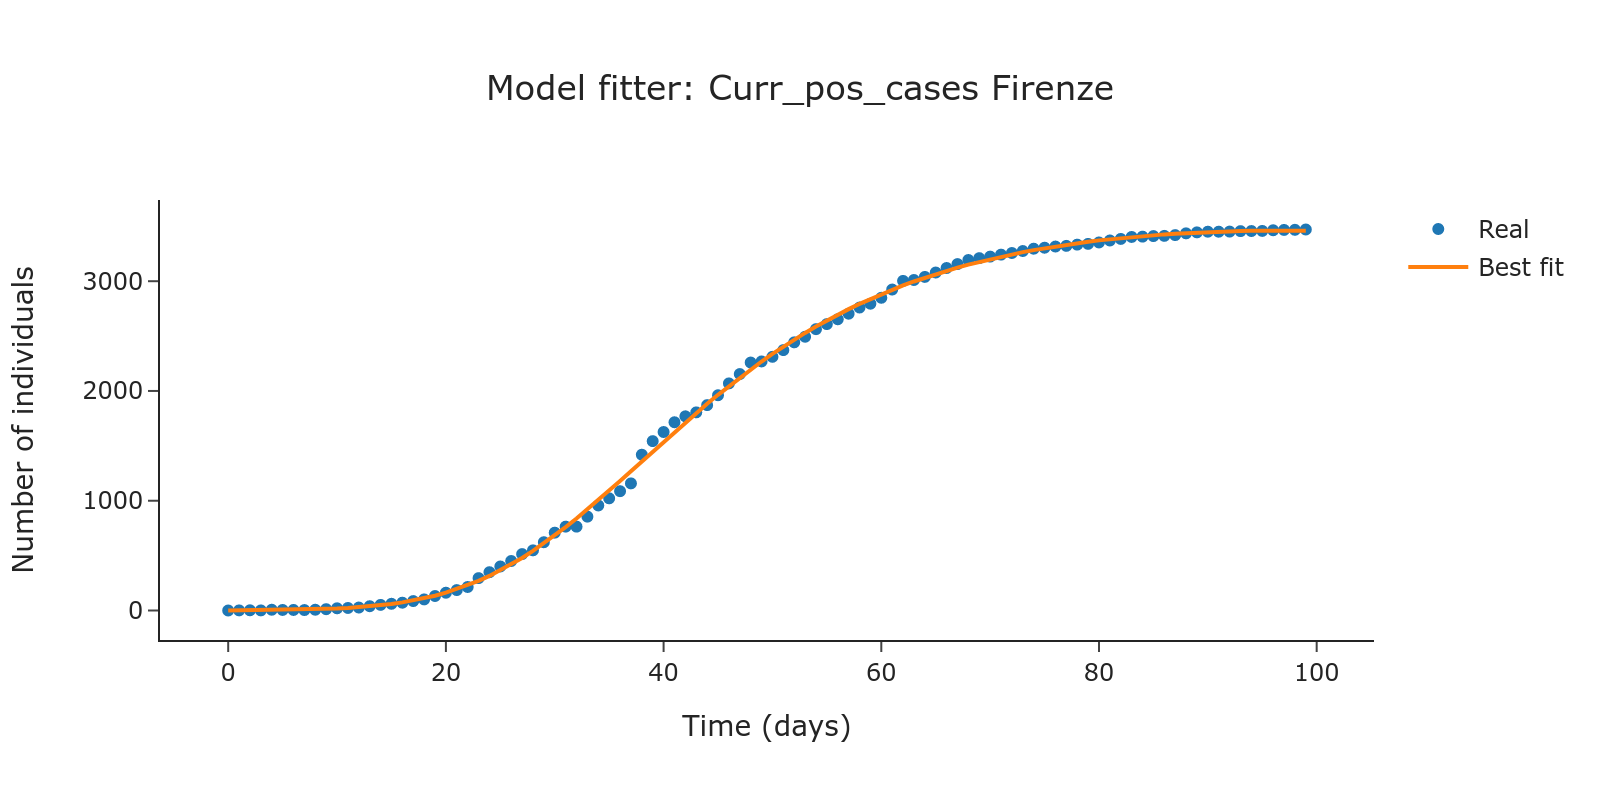

In [19]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [20]:
province = 'Firenze'
compart = 'New_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

result = mod.fit(y_data, params, method="leastsq", x=x_data)
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 467
    # data points      = 100
    # variables        = 6
    chi-square         = 5137.54834
    reduced chi-square = 54.6547696
    Akaike info crit   = 405.916108
    Bayesian info crit = 421.547129
[[Variables]]
    R_0_start:  3.05288038 +/- 413.392448 (13541.06%) (init = 3.5)
    k:          0.14421469 +/- 0.05549546 (38.48%) (init = 0.3)
    x0:         35.1144714 +/- 2.75302411 (7.84%) (init = 20)
    R_0_end:    1.75653544 +/- 62.2097625 (3541.62%) (init = 0.9)
    alpha:      0.21732658 +/- 47.6931081 (21945.36%) (init = 0.1)
    gamma:      0.16314855 +/- 46.7198532 (28636.39%) (init = 0.1428571)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_start, gamma)   = -0.993
    C(alpha, gamma)       =  0.980
    C(R_0_start, alpha)   = -0.949
    C(x0, alpha)          = -0.934
    C(x0, gamma)          = -0.928
    C(k, alpha)           =  0.910
    C(R_0_start, x0)      =  0.906
    C(

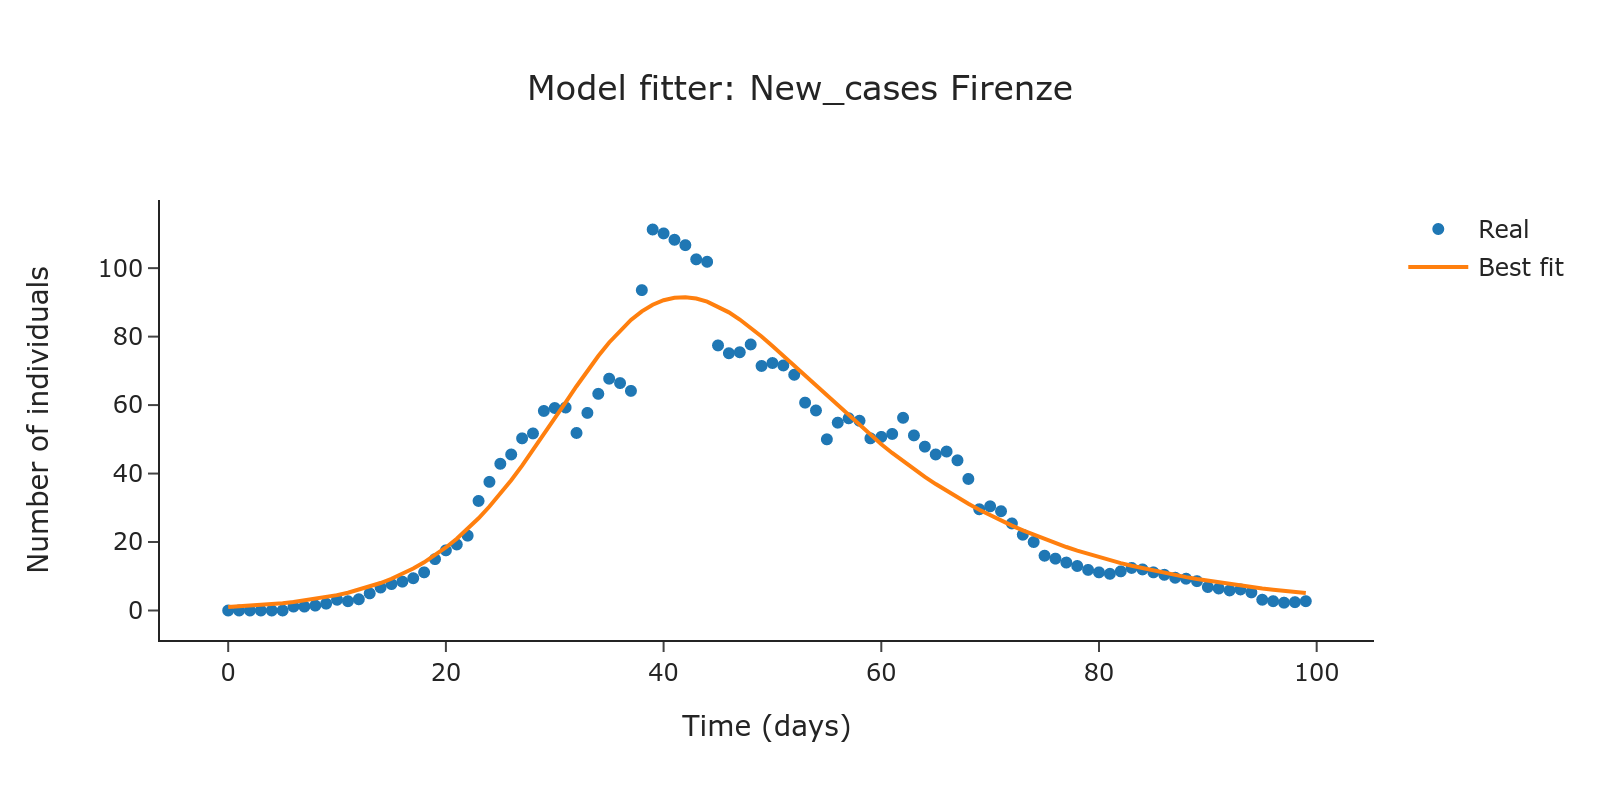

In [21]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

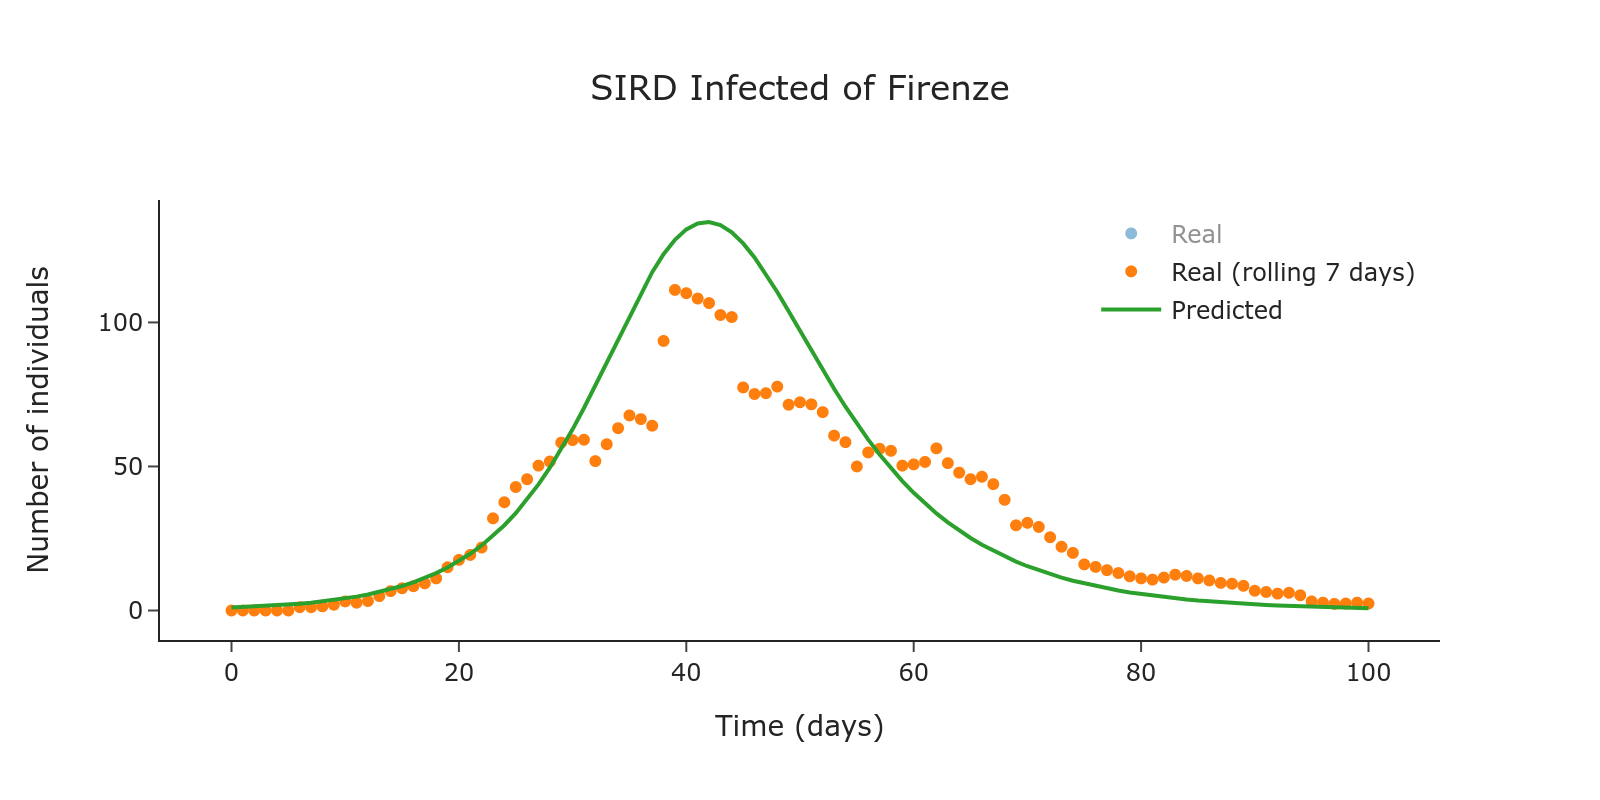

In [22]:
sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

names, title, data, _ = data_for_plot('Infected', covidpro_df, mapping, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

In [23]:
province = 'Bologna'
compart = 'New_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df, outbreak_shift=0)

In [24]:
result = mod.fit(y_data, params, method="leastsq", x=x_data)
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 728
    # data points      = 100
    # variables        = 6
    chi-square         = 5177.09762
    reduced chi-square = 55.0755066
    Akaike info crit   = 406.682969
    Bayesian info crit = 422.313990
[[Variables]]
    R_0_start:  3.85781475 +/- 0.77411065 (20.07%) (init = 3.5)
    k:          0.75424466 +/- 0.26522806 (35.16%) (init = 0.3)
    x0:         32.6953830 +/- 0.32227397 (0.99%) (init = 20)
    R_0_end:    3.15554101 +/- 0.46050078 (14.59%) (init = 0.9)
    alpha:      0.84599519 +/- 2.05883003 (243.36%) (init = 0.1)
    gamma:      0.27053191 +/- 0.46207082 (170.80%) (init = 0.1428571)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, gamma)       =  1.000
    C(R_0_start, gamma)   = -1.000
    C(R_0_start, alpha)   = -1.000
    C(R_0_end, alpha)     =  1.000
    C(R_0_end, gamma)     =  1.000
    C(R_0_start, R_0_end) = -1.000
    C(k, R_0_end)         =  0.261
    C(R_0_start

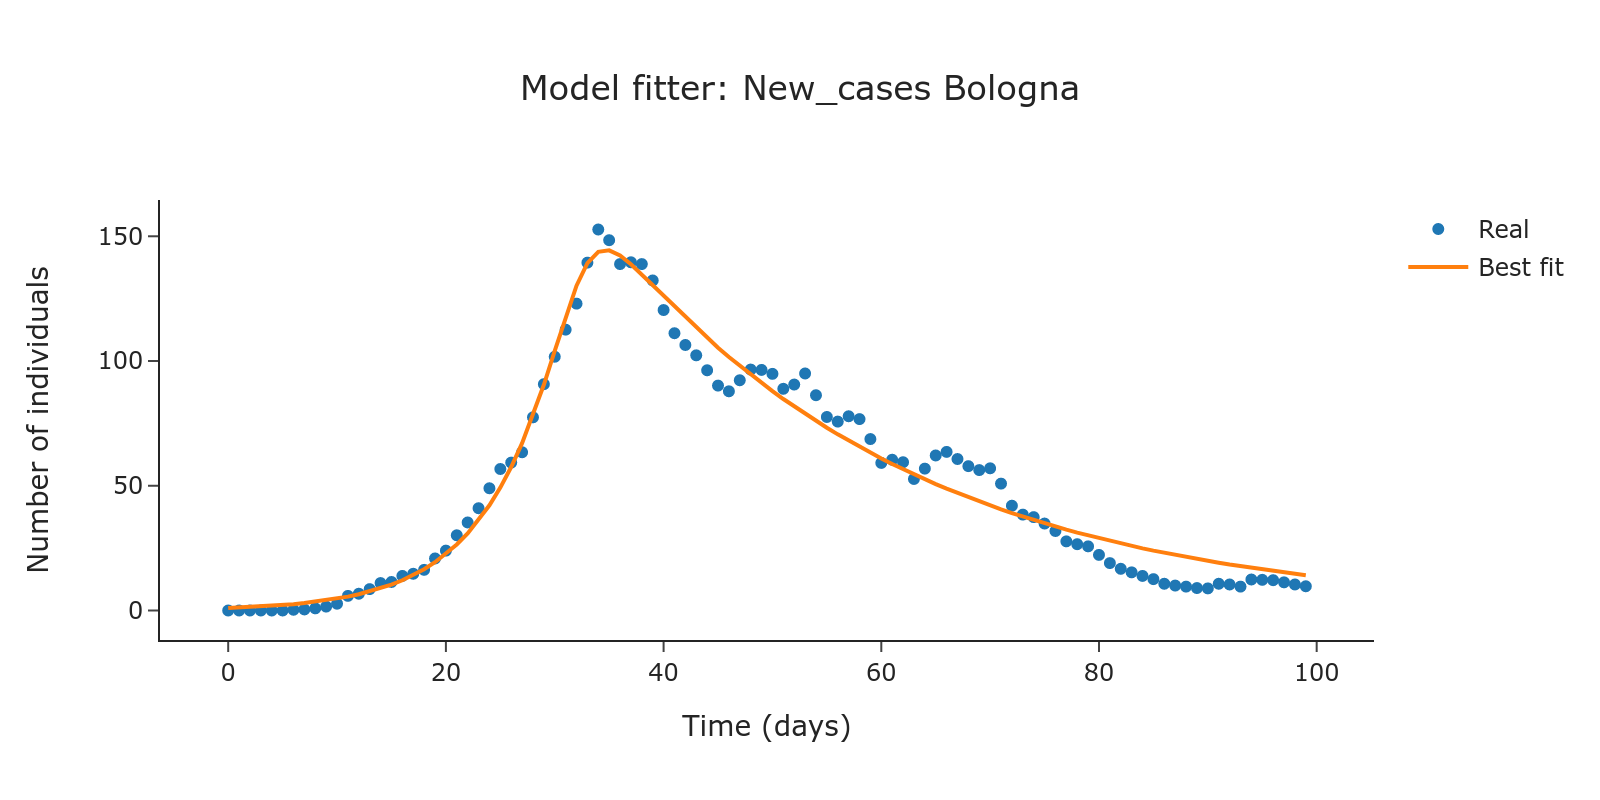

In [25]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

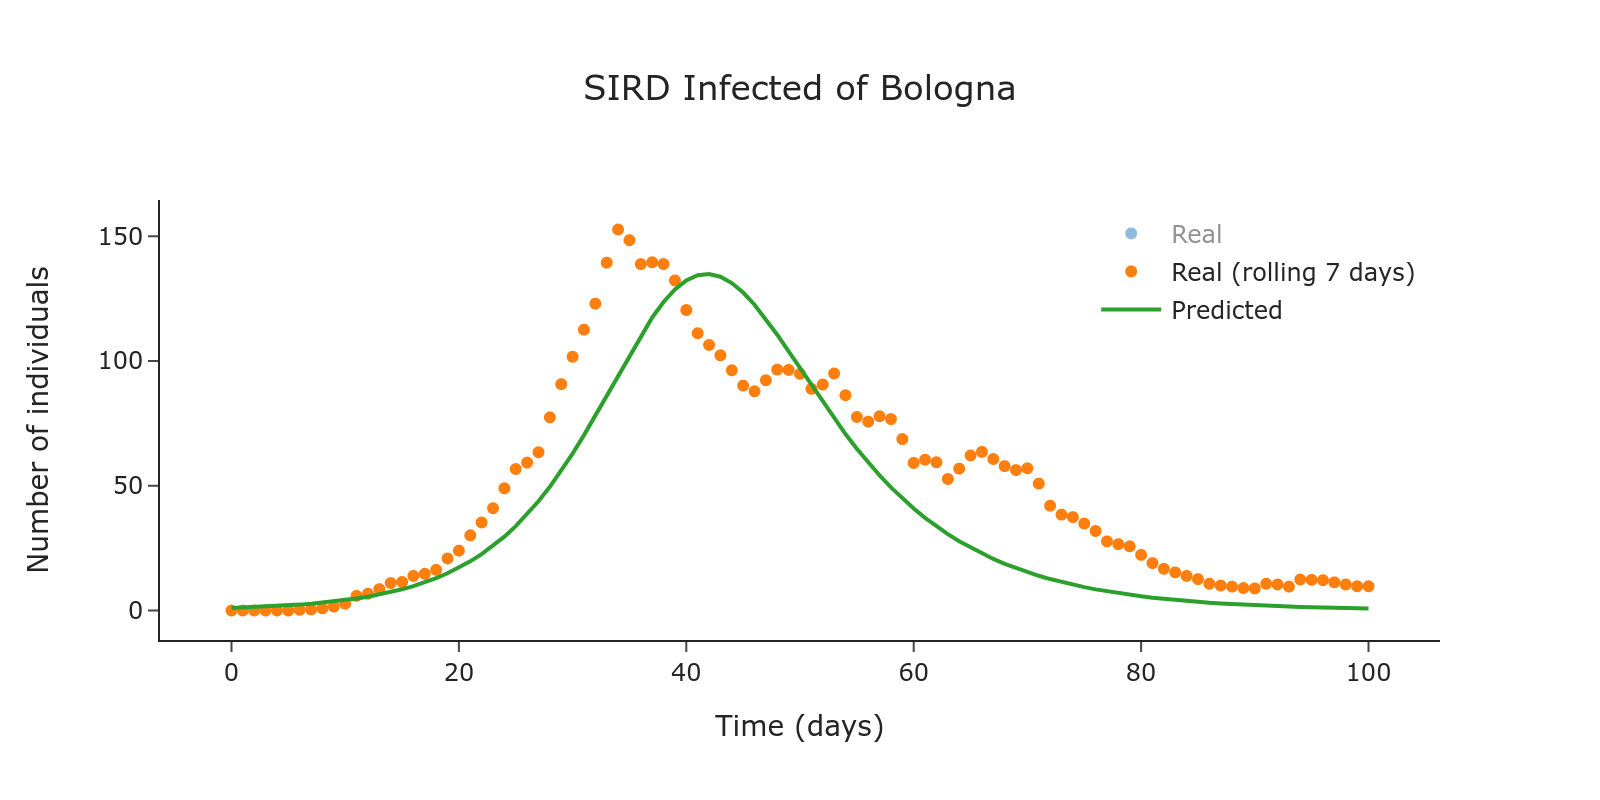

In [26]:
sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

names, title, data, _ = data_for_plot('Infected', covidpro_df, mapping, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])